# Data Analysis on Linkedin and Indeed

  #### <a href="#linkedin">1. Linkedin</a>
  #### &emsp; <a href="#lin1">1.1 Overall Description</a>
  #### &emsp; <a href="#lin2">1.2 Titles Analysis</a>
  #### &emsp; <a href="#lin3">1.3 Location Analysis</a>
  #### &emsp; <a href="#lin4">1.4 Keywords Extraction</a>
  #### <a href="#indeed">2. Indeed</a>
  #### &emsp; <a href="#ind1">2.1 Overall Description</a>
  #### &emsp; <a href="#ind2">2.2 Data Preprocess</a>
  #### &emsp; <a href="#ind3">2.3 Skills vs Salaries</a>
  #### &emsp; <a href="#ind4">2.4 Skills vs Industries</a>
  #### &emsp; <a href="#ind5">2.5 Skills Clusters</a>
  #### <a href="#reference">3. Reference</a>

## <div id="linkedin">1. Linkedin</div>
### <div id="lin1">1.1 Overall Description</div>
Linkedin dataset was crawled with nodejs on [linked jobs](https://www.linkedin.com/jobs/).

In [1]:
import sys
import collections
import random
import numpy as np
import pandas as pd
from IPython.display import display
import seaborn as sns
import nltk
try: nltk.data.find('tokenizers/punkt')
except LookupError: nltk.download('punkt')
try: nltk.data.find('corpora/stopwords')
except LookupError: nltk.download('stopwords')
try: nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError: nltk.download('averaged_perceptron_tagger')
try: nltk.data.find('chunkers/maxent_ne_chunker')
except LookupError: nltk.download('maxent_ne_chunker')
try: nltk.data.find('corpora/words')
except LookupError: nltk.download('words')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fname = 'https://raw.githubusercontent.com/liuweilin17/mie1624/master/project/data/linkedin_jobs.csv'
df = pd.read_csv(fname)

In [3]:
df.head()

,Query,Location,Title,Company,Place,Link,Length,Description
0,data scientist,Canada,Data Scientist I,TD,"Markham, Ontario, Canada",https://ca.linkedin.com/jobs/view/data-scienti...,4432,TD Description Tell us your story. Don't go un...
1,data scientist,Canada,Data Scientist,RBC,"Toronto, Ontario, Canada",https://ca.linkedin.com/jobs/view/data-scienti...,5363,What is the Opportunity? We have multiple oppo...
2,data scientist,Canada,Data Scientist,Perennial Inc.,"Toronto, Ontario, Canada",https://ca.linkedin.com/jobs/view/data-scienti...,5949,"Position Title: Data Scientist, Perennial DCM ..."
3,data scientist,Canada,Lead Data Scientist (100% REMOTE ANYWHERE IN C...,GoSecure,"Montreal, Quebec, Canada",https://ca.linkedin.com/jobs/view/lead-data-sc...,4374,**** This position could be 100% remote anywhe...
4,data scientist,Canada,Junior Data Scientist,Game Hive,"Toronto, Ontario, Canada",https://ca.linkedin.com/jobs/view/junior-data-...,4748,Game Hive is building a new generation of casu...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5973 entries, 0 to 5972
Data columns (total 8 columns):
Query          5973 non-null object
Location       5973 non-null object
Title          5973 non-null object
Company        5973 non-null object
Place          5973 non-null object
Link           5973 non-null object
Length         5973 non-null int64
Description    5973 non-null object
dtypes: int64(1), object(7)
memory usage: 373.4+ KB


In [5]:
df.describe()

,Length
count,5973.000000
mean,3555.521011
std,1841.454667
min,92.000000
25%,2311.000000
50%,3366.000000
75%,4533.000000
max,21267.000000


In [6]:
for col in df.columns:
    print(col + ':')
    us = df[col].unique()
    if col != 'Description' and col != 'Link':
        print(us[:10])
    print('----------------')

Query:
['data scientist' 'data engineer' 'data analyst']
----------------
Location:
['Canada' 'United States']
----------------
Title:
['Data Scientist I' 'Data Scientist'
 'Lead Data Scientist (100% REMOTE ANYWHERE IN CANADA)'
 'Junior Data Scientist' 'Graduate Data Scientist' 'Staff data scientist'
 'Data Scientist (AI)' 'Research Data Scientist' 'Data Scientist, Manager'
 'Data Scientist - Planning Team']
----------------
Company:
['TD' 'RBC' 'Perennial Inc.' 'GoSecure' 'Game Hive' 'Rio Tinto'
 'AstraZeneca' 'Postmates Inc.' 'Shopify' 'MOJIO INC.']
----------------
Place:
['Markham, Ontario, Canada' 'Toronto, Ontario, Canada'
 'Montreal, Quebec, Canada' 'Kitimat, British Columbia, Canada' 'Canada'
 'Vancouver, British Columbia, Canada' 'Ottawa, Ontario, Canada'
 'Calgary, Alberta, Canada' 'Burnaby, British Columbia, Canada'
 'Windsor, Ontario, Canada']
----------------
Link:
----------------
Length:
[4432 5363 5949 4374 4748 4497 4999 4903 3126 3401]
----------------
Description:
--

### <div id="lin2">1.2 Titles Analysis</div>
Our datasets are the search results of **data scientist, data engineer and data analyst**. In this section, we attempt to go deep into the detailed job titles in the job postings.

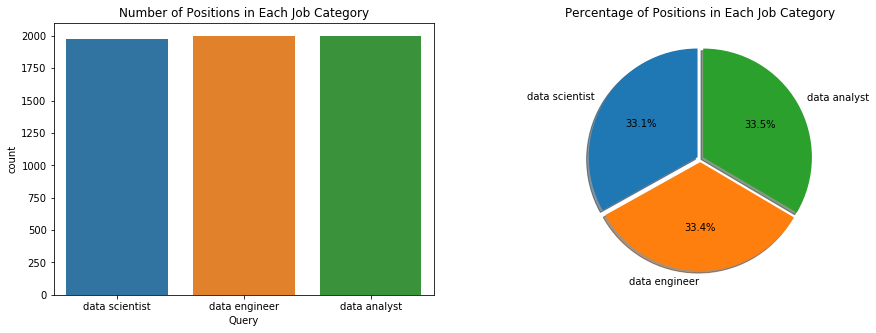

- Total number of unique titles:  1979


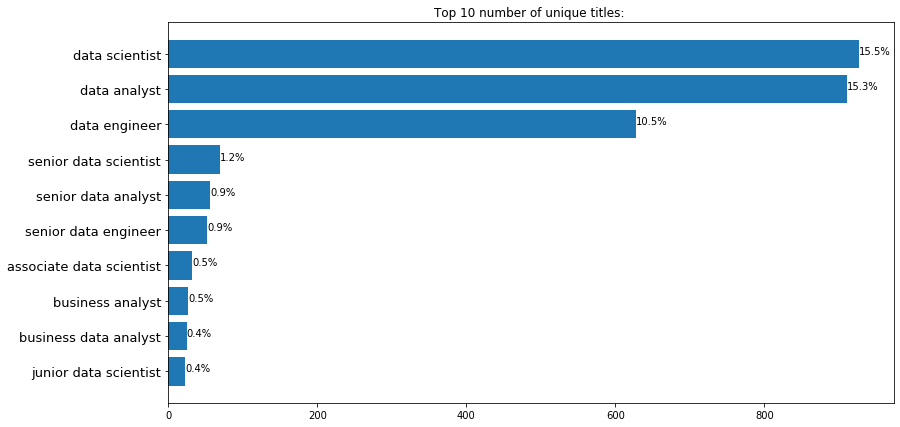

In [7]:
import re

reg_brackets = re.compile('[\(\[].*?[\)\]]')

def set_plot(xs=10, ys=10):
    plt.rc('xtick', labelsize=xs)
    plt.rc('ytick', labelsize=ys)

def clean_title(title):
    title = reg_brackets.sub("", title) # remve brankets
    title = ''.join([c.lower() for c in title]) # lowercase
    title = title.strip()
    return title

def title_info(df, top=10, rms=[]):
    titles_dt = collections.Counter(df['Title'])
    for rm in rms:
        if rm in titles_dt:
            del titles_dt[rm]
    titles_sorted = sorted(titles_dt.keys(), key=lambda x:titles_dt[x])
    total = df.shape[0]
    print('- Total number of unique titles: ', len(titles_sorted))
    tops = titles_sorted[-top:]
    set_plot(ys=13)
#     for title in tops:
#         print('  {}: {}, {}%'.format(title, titles_dt[title], format(titles_dt[title]/total*100, '.2f')))
    plt.figure(figsize=(13,7))
    x = tops
    y = [titles_dt[t] for t in tops]
    plt.barh(x, y)
    for index, value in enumerate(y):
        txt = '{}%'.format(format(value/total*100, '.1f'))
        plt.text(value, index, txt)
    plt.title('Top {} number of unique titles: '.format(top))
    plt.show()
    
set_plot()
fig, axs = plt.subplots(1, 2, figsize=(15,5))
# Count Plot
sns.countplot(x='Query', data=df, ax=axs[0])
axs[0].set_title("Number of Positions in Each Job Category")
# Percentage Plot
query_dt = collections.Counter(df['Query'])
queries = query_dt.keys()
percent = [query_dt[q]/len(df['Query']) for q in queries]
explode = [0.03 for _ in range(len(queries))]
axs[1].pie(percent, labels=queries, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
axs[1].set_title('Percentage of Positions in Each Job Category')
plt.show()

df['Title'] = df['Title'].map(clean_title)
title_info(df)
# title_info(df, rms=['data scientist', 'data analyst', 'data engineer'])

-Data scientists Total number of unique titles: 723
-Data analyst Total number of unique titles: 962
-Data engineer Total number of unique titles: 684


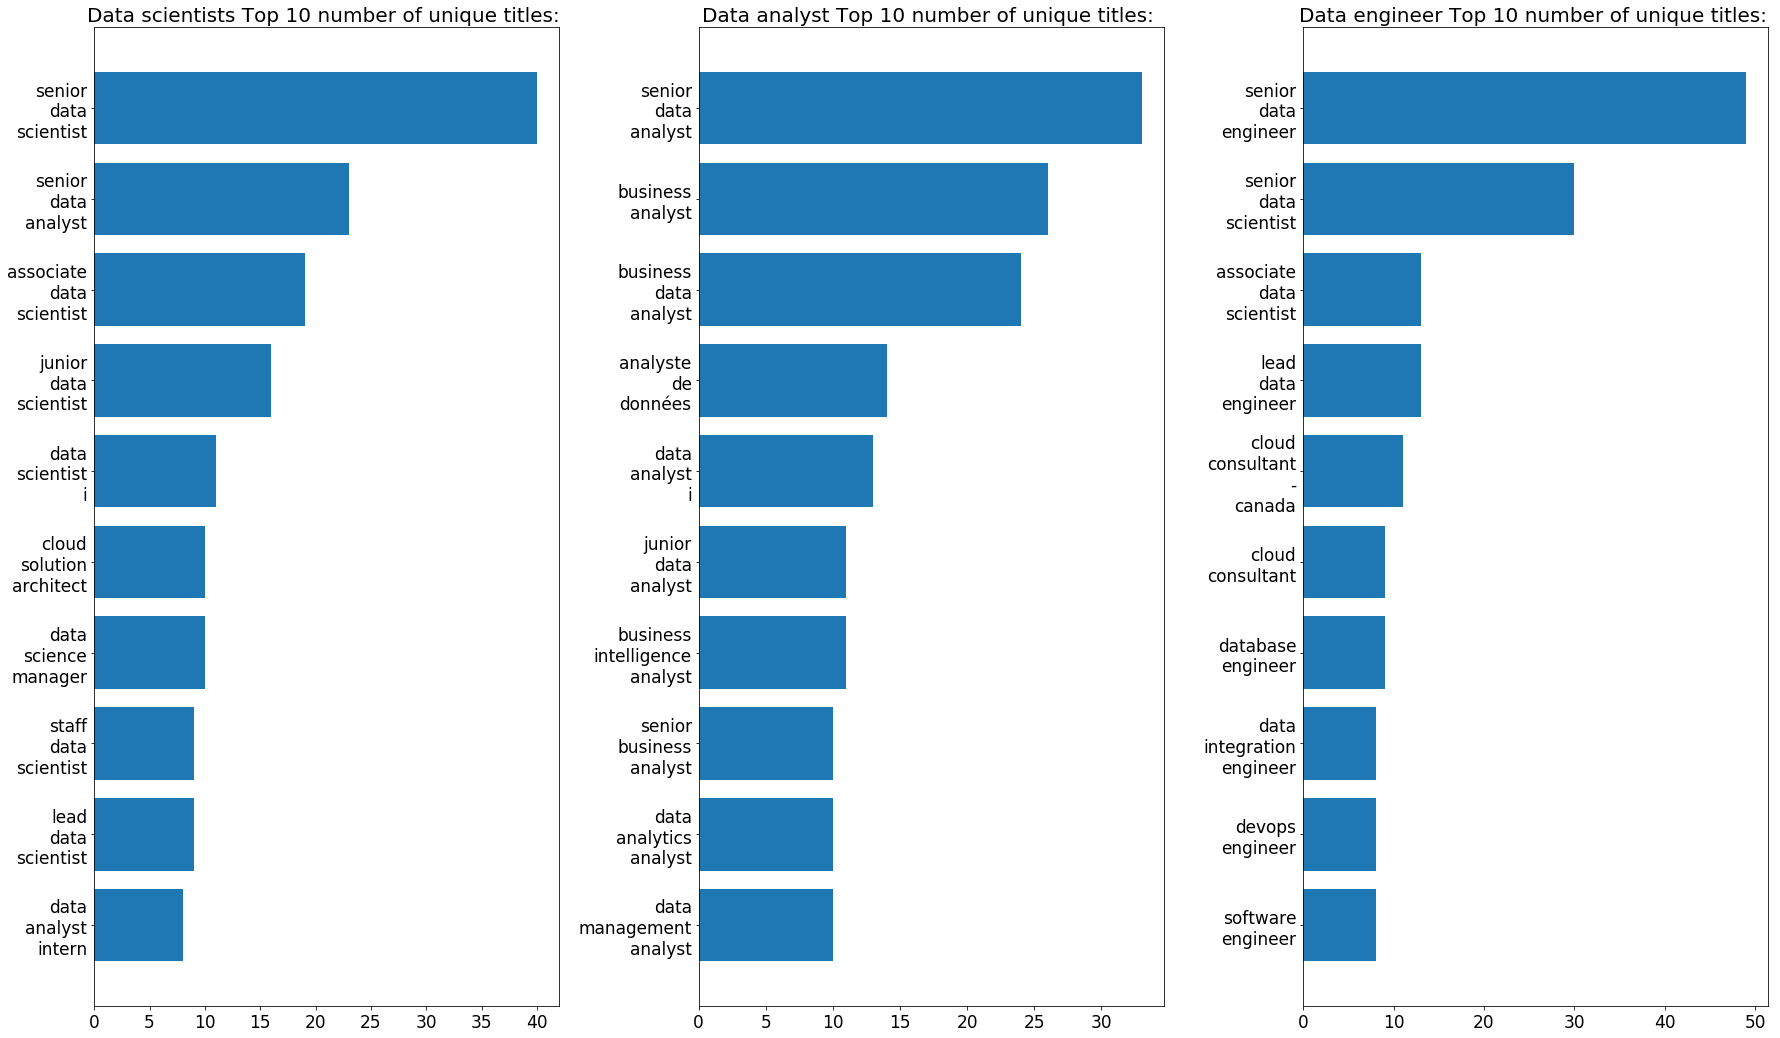

In [8]:
def title_info_new(df, ax, top=10, rms=[], title=""):
    titles_dt = collections.Counter(df['Title'])
    for rm in rms:
        if rm in titles_dt:
            del titles_dt[rm]
    titles_sorted = sorted(titles_dt.keys(), key=lambda x:titles_dt[x])
    total = df.shape[0]
    print('-{} Total number of unique titles: {}'.format(title, len(titles_sorted)))
    tops = titles_sorted[-top:]
    x = [re.sub(' ', '\n', t) for t in tops]
    y = [titles_dt[t] for t in tops]
    ax.barh(x, y)
#     for index, value in enumerate(y):
#         txt = '{}%'.format(format(value/total*100, '.1f'))
#         plt.text(value, index, txt)
    ax.set_title('{} Top {} number of unique titles: '.format(title, top), fontsize=20)
    # plt.show()

set_plot(xs=17, ys=17)
fig, axs = plt.subplots(1, 3, figsize=(30,18))
plt.subplots_adjust(wspace=0.3)
rms=['data scientist', 'data analyst', 'data engineer']
df_scientist = df[df['Query']=='data scientist']
df_analyst = df[df['Query']=='data analyst']
df_engineer = df[df['Query']=='data engineer']

title_info_new(df_scientist, axs[0], rms=rms, title="Data scientists")
title_info_new(df_analyst, axs[1], rms=rms, title="Data analyst")
title_info_new(df_engineer, axs[2], rms=rms, title="Data engineer")
plt.show()

We found that **'Senior' or 'Lead'** positions are mostly wanted in the job market for data scientist, data analyst, data engineer. In the same time, for **data analyst**, the job title frequently contains **business**, which indicates having a background of business could make the candiates be more competitive. For **data engineer**, the jobs titles contains lots of words related to **software engineering**, such as database, cloud, software, devops, etc. People with background of both data and software engineering could be more equal to data engineer positions.

### <div id="lin3">1.3 Location Analysis</div>
The location of the jobs are in **Canada** and **United States**. In this section, we attempt to analyze the impact of locations.

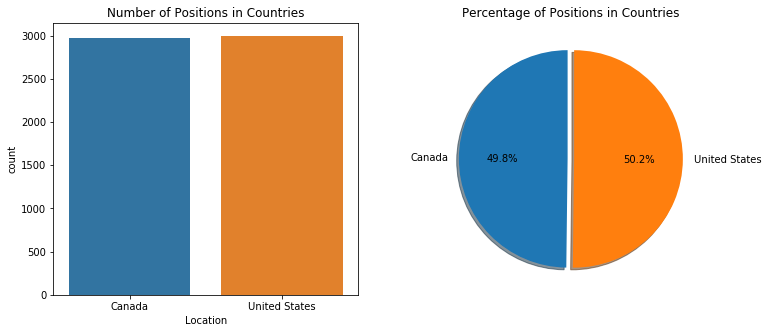

- Total number of unique places:  679


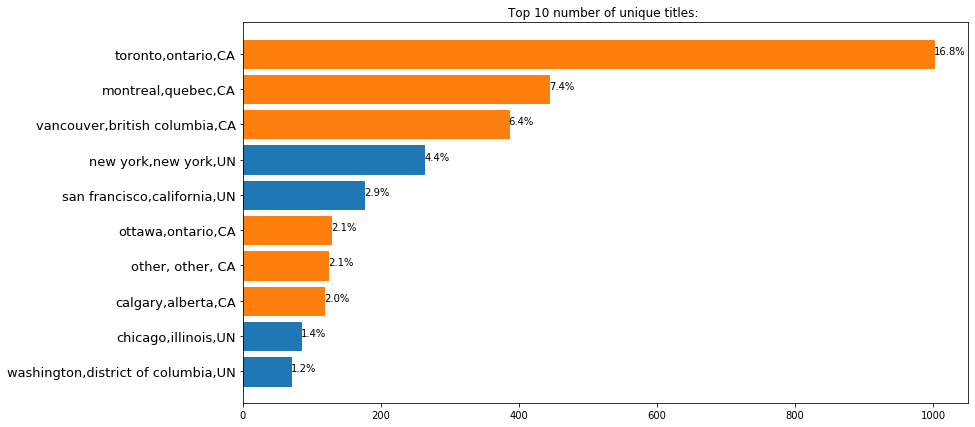

In [9]:
def clean_place(place):
    countries = ['canada', 'united states']
    place_lst = place.split(',')
    place_lst = [place.strip() for place in place_lst]
    place = ','.join(place_lst)
    place = ''.join([c.lower() for c in place]) # lowercase
    place = place.strip()
    return place

def format_place(place):
    if place == 'canada' or place == 'united states':
        place = 'other, other, ' + place
    place = re.sub("canada", "CA", place)
    place = re.sub("united states", "UN", place)
    return place

def place_info(df, top=10, rms=[]):
    places_dt = collections.Counter(df['Place'])
    for rm in rms:
        if rm in places_dt:
            del places_dt[rm]
    places_sorted = sorted(places_dt.keys(), key=lambda x:places_dt[x])
    total = df.shape[0]
    print('- Total number of unique places: ', len(places_sorted))
    tops = places_sorted[-top:]
    set_plot(ys=13)
    plt.figure(figsize=(13,7))
    x = tops
    y = [places_dt[t] for t in tops]
    bars = plt.barh(x, y)
    # set color
    for i in range(len(bars)):
        color = 'tab:orange' if x[i][-2:].lower()== 'ca' else 'tab:blue'
        bars[i].set_color(color)
    for index, value in enumerate(y):
        txt = '{}%'.format(format(value/total*100, '.1f'))
        plt.text(value, index, txt)
    plt.title('Top {} number of unique titles: '.format(top))
    plt.show()

set_plot()
fig, axs = plt.subplots(1, 2, figsize=(12,5))
# Count Plot
sns.countplot(x='Location', data=df, ax=axs[0])
axs[0].set_title("Number of Positions in Countries")
# Percentage Plot
loc_dt = collections.Counter(df['Location'])
locs = loc_dt.keys()
percent = [loc_dt[l]/len(df['Location']) for l in locs]
explode = [0.03 for _ in range(len(locs))]
axs[1].pie(percent, labels=locs, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
axs[1].set_title('Percentage of Positions in Countries')
plt.show()

df['Place'] = df['Place'].map(clean_place)
df['Place'] = df['Place'].map(format_place)
place_info(df)

-Canada Total number of unique places: 110
-United States Total number of unique places: 567


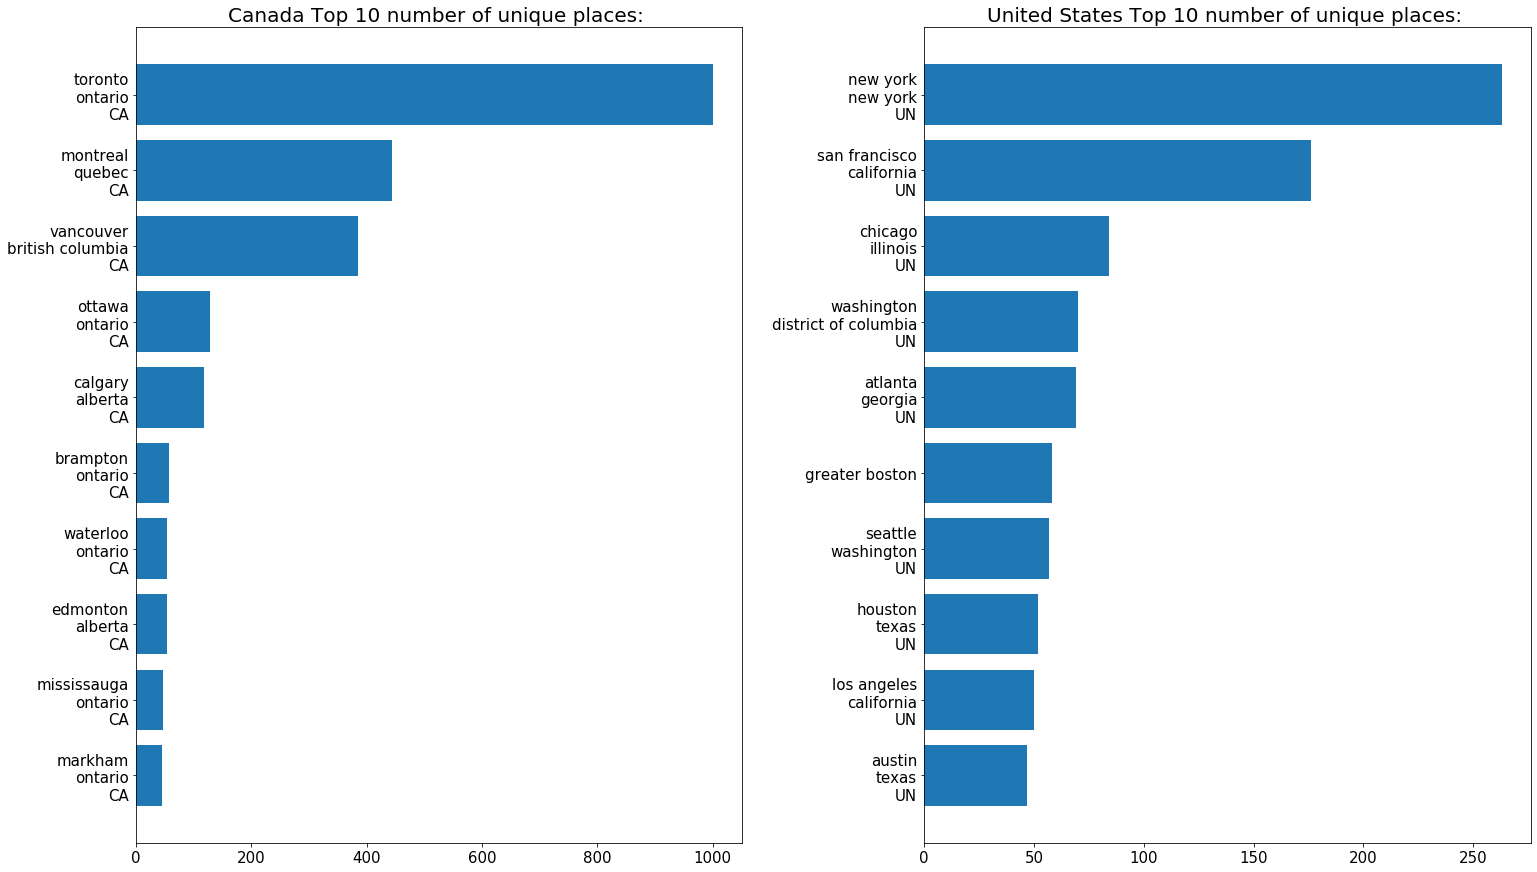

In [10]:
def place_info_new(df, ax, top=10, rms=[], title=""):
    places_dt = collections.Counter(df['Place'])
    for rm in rms:
        if rm in places_dt:
            del places_dt[rm]
    places_sorted = sorted(places_dt.keys(), key=lambda x:places_dt[x])
    total = df.shape[0]
    print('-{} Total number of unique places: {}'.format(title, len(places_sorted)))
    tops = places_sorted[-top:]
    x = [re.sub(',', '\n', t) for t in tops]
    y = [places_dt[t] for t in tops]
    ax.barh(x, y)
#     for index, value in enumerate(y):
#         plt.text(value, index, str(value))
    ax.set_title('{} Top {} number of unique places: '.format(title, top), fontsize=20)
    # plt.show()
    
set_plot(xs=15, ys=15)
fig, axs = plt.subplots(1, 2, figsize=(25,15))
plt.subplots_adjust(wspace=0.3)
rms=['other, other, CA', 'other, other, UN']
df_ca = df[df['Location']=='Canada']
df_un = df[df['Location']=='United States']

place_info_new(df_ca, axs[0], rms=rms, title="Canada")
place_info_new(df_un, axs[1], rms=rms, title="United States")

Among all cities in both Canada and United States, **Toronto** tend to have the highest number of positions related to data science. In Canada, **Toronto, Montreal, Vancouver, Ottowa and Cagary** are the top 5 cities wanted for employees in data science. In United States, **New York, San Francisco, Chicago, Washington and Atlanta** are the top 5 cities wanted for employees in data science.

### <div id="lin4">1.4 Keywords Extraction</div>
Our datasets also contains the descriptions of the jobs. In this section, we attempt to extract some keywords from these job descriptions

In [11]:
def select(countries, titles):
    # select rows given countries and titles
    df_new = df[(df.Query.isin(titles)) & (df.Location.isin(countries))]
    return df_new

def basic_analysis(df):
    # number of words
    raw = ' '.join(df_new['Description'])
    print('raw words number: ', len(raw))
    
    # tokenize: break up the string into words and punctuation by
    # removing whitespace, line breaks, blank lines
    tokens = nltk.word_tokenize(raw)
    words = [w.lower() for w in tokens]
    print('tokens number: ', len(words))
    
    # set tokens back to Text for further analyze
    text = nltk.Text(words)
    # Frequent bigrams
    # print('Frquenct bigrams: ', text.collocations())
    
    # number of vocabulary
    voc = set(words)
    print('vocabulary size: ', len(voc))
    
    # frequency distribution
    fdist = nltk.FreqDist(text)
    print(fdist)
    print(fdist.most_common(10))
    # plot the frequency distribution
    display(fdist.plot())
    display(fdist.plot(cumulative=True))
    
def chunk1(sent):
    # https://www.nltk.org/book/ch07.html
    entities = []
    sent = nltk.pos_tag(sent)
    nes = nltk.ne_chunk(sent)
    for ne in nes:
        if type(ne) is not tuple:
            tmp = ' '.join([w for w, t in ne.leaves()])
            entities.append(tmp)
    return entities

from rake_nltk import Rake
r = Rake()
def chunk2(sent):
    # https://www.github.com/csurfer/rake-nltk
    sent = ' '.join(sent)
    r.extract_keywords_from_text(sent)
    return r.get_ranked_phrases()
    
def analyze(df, chunk_tag, stop_words):
    entities_count = collections.defaultdict(int)
    for sentences in df['Description']:
#         sentences = nltk.sent_tokenize(raw)
#         sentences = [nltk.word_tokenize(sent) for sent in sentences]
        for sent in sentences:
            if chunk_tag == 1:
                entities = chunk1(sent)
            elif chunk_tag == 2:
                entities = chunk2(sent)
            else:
                pass
            if not entities:
                continue
            for en in entities:
                if en not in stop_words:
                    entities_count[en] += 1
    
    # sorted_entities = sorted(entities_count.keys(), key=lambda x:entities_count[x], reverse=True)
    # print([(en, entities_count[en]) for en in sorted_entities[:50]])
    return entities_count

def draw_bar(entities_count, ax, top=20, title=""):
    entities_sorted = sorted(entities_count.keys(), key=lambda x:entities_count[x])
    total = sum(entities_count.values())
    print('-{} Total number of keywords: {}'.format(title, len(entities_sorted)))
    tops = entities_sorted[-top:]
    x = [re.sub(' ', '\n', t) for t in tops]
    y = [entities_count[t] for t in tops]
    ax.barh(x, y)
#     for index, value in enumerate(y):
#         plt.text(value, index, str(value))
    ax.set_title('{} Top {} number of keywords: '.format(title, top), fontsize=20)
    
# word cloud
def draw_cloud(entities_count, ax, top=50):
    entities_sorted = sorted(entities_count.keys(), key=lambda x:entities_count[x])[-top:]
    s = []
    for en, cnt in entities_count.items():
        s += [en for _ in range(cnt)]
    random.shuffle(s)
    wcloud = WordCloud(background_color='white',
                          stopwords=[],
                          max_words=100,
                          max_font_size=30,
                          random_state=42,
                        ).generate(','.join(s))
    # plt.figure(figsize=(20,20))
    # plt.imshow(wcloud)
    # plt.axis('off')
    # plt.show()
    ax.imshow(wcloud)
    ax.axis('off')
    
def tokenize_description(description):
    sentences = nltk.sent_tokenize(description)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    return sentences

def remove_words(entities_count, stop_words):
    for w in stop_words:
        if w in entities_count:
            w = w.strip()
            del entities_count[w]
            
    return entities_count

In [12]:
# Tokenize Description
df['Description'] = df['Description'].map(tokenize_description)
print("- Descripion Tokenize Done.")

stop_words = ['Canada', 'Data', 'Strong', 'Job', 'Work', 'Good', 'Engineering', 'Please', 
             'Create', 'PhD', 'Ontario', 'Ability', 'Experience', 'Skill', 'Data Science',
             'Data Analyst', 'Toronto']
entities_dt = {}
for country in df['Location'].unique():
    for title in df['Query'].unique():
        sub_df = select([country], [title])
        print('- Number of jobs of {} in {}: {}'.format(title, country, sub_df.shape))
        entities_count = analyze(sub_df, 1, stop_words)
        entities_dt[(country, title)] = entities_count

- Descripion Tokenize Done.
- Number of jobs of data scientist in Canada: (978, 8)
- Number of jobs of data engineer in Canada: (997, 8)
- Number of jobs of data analyst in Canada: (1000, 8)
- Number of jobs of data scientist in United States: (999, 8)
- Number of jobs of data engineer in United States: (999, 8)
- Number of jobs of data analyst in United States: (1000, 8)


- data scientist keywords in Canada
- Total number of keywords: 7771


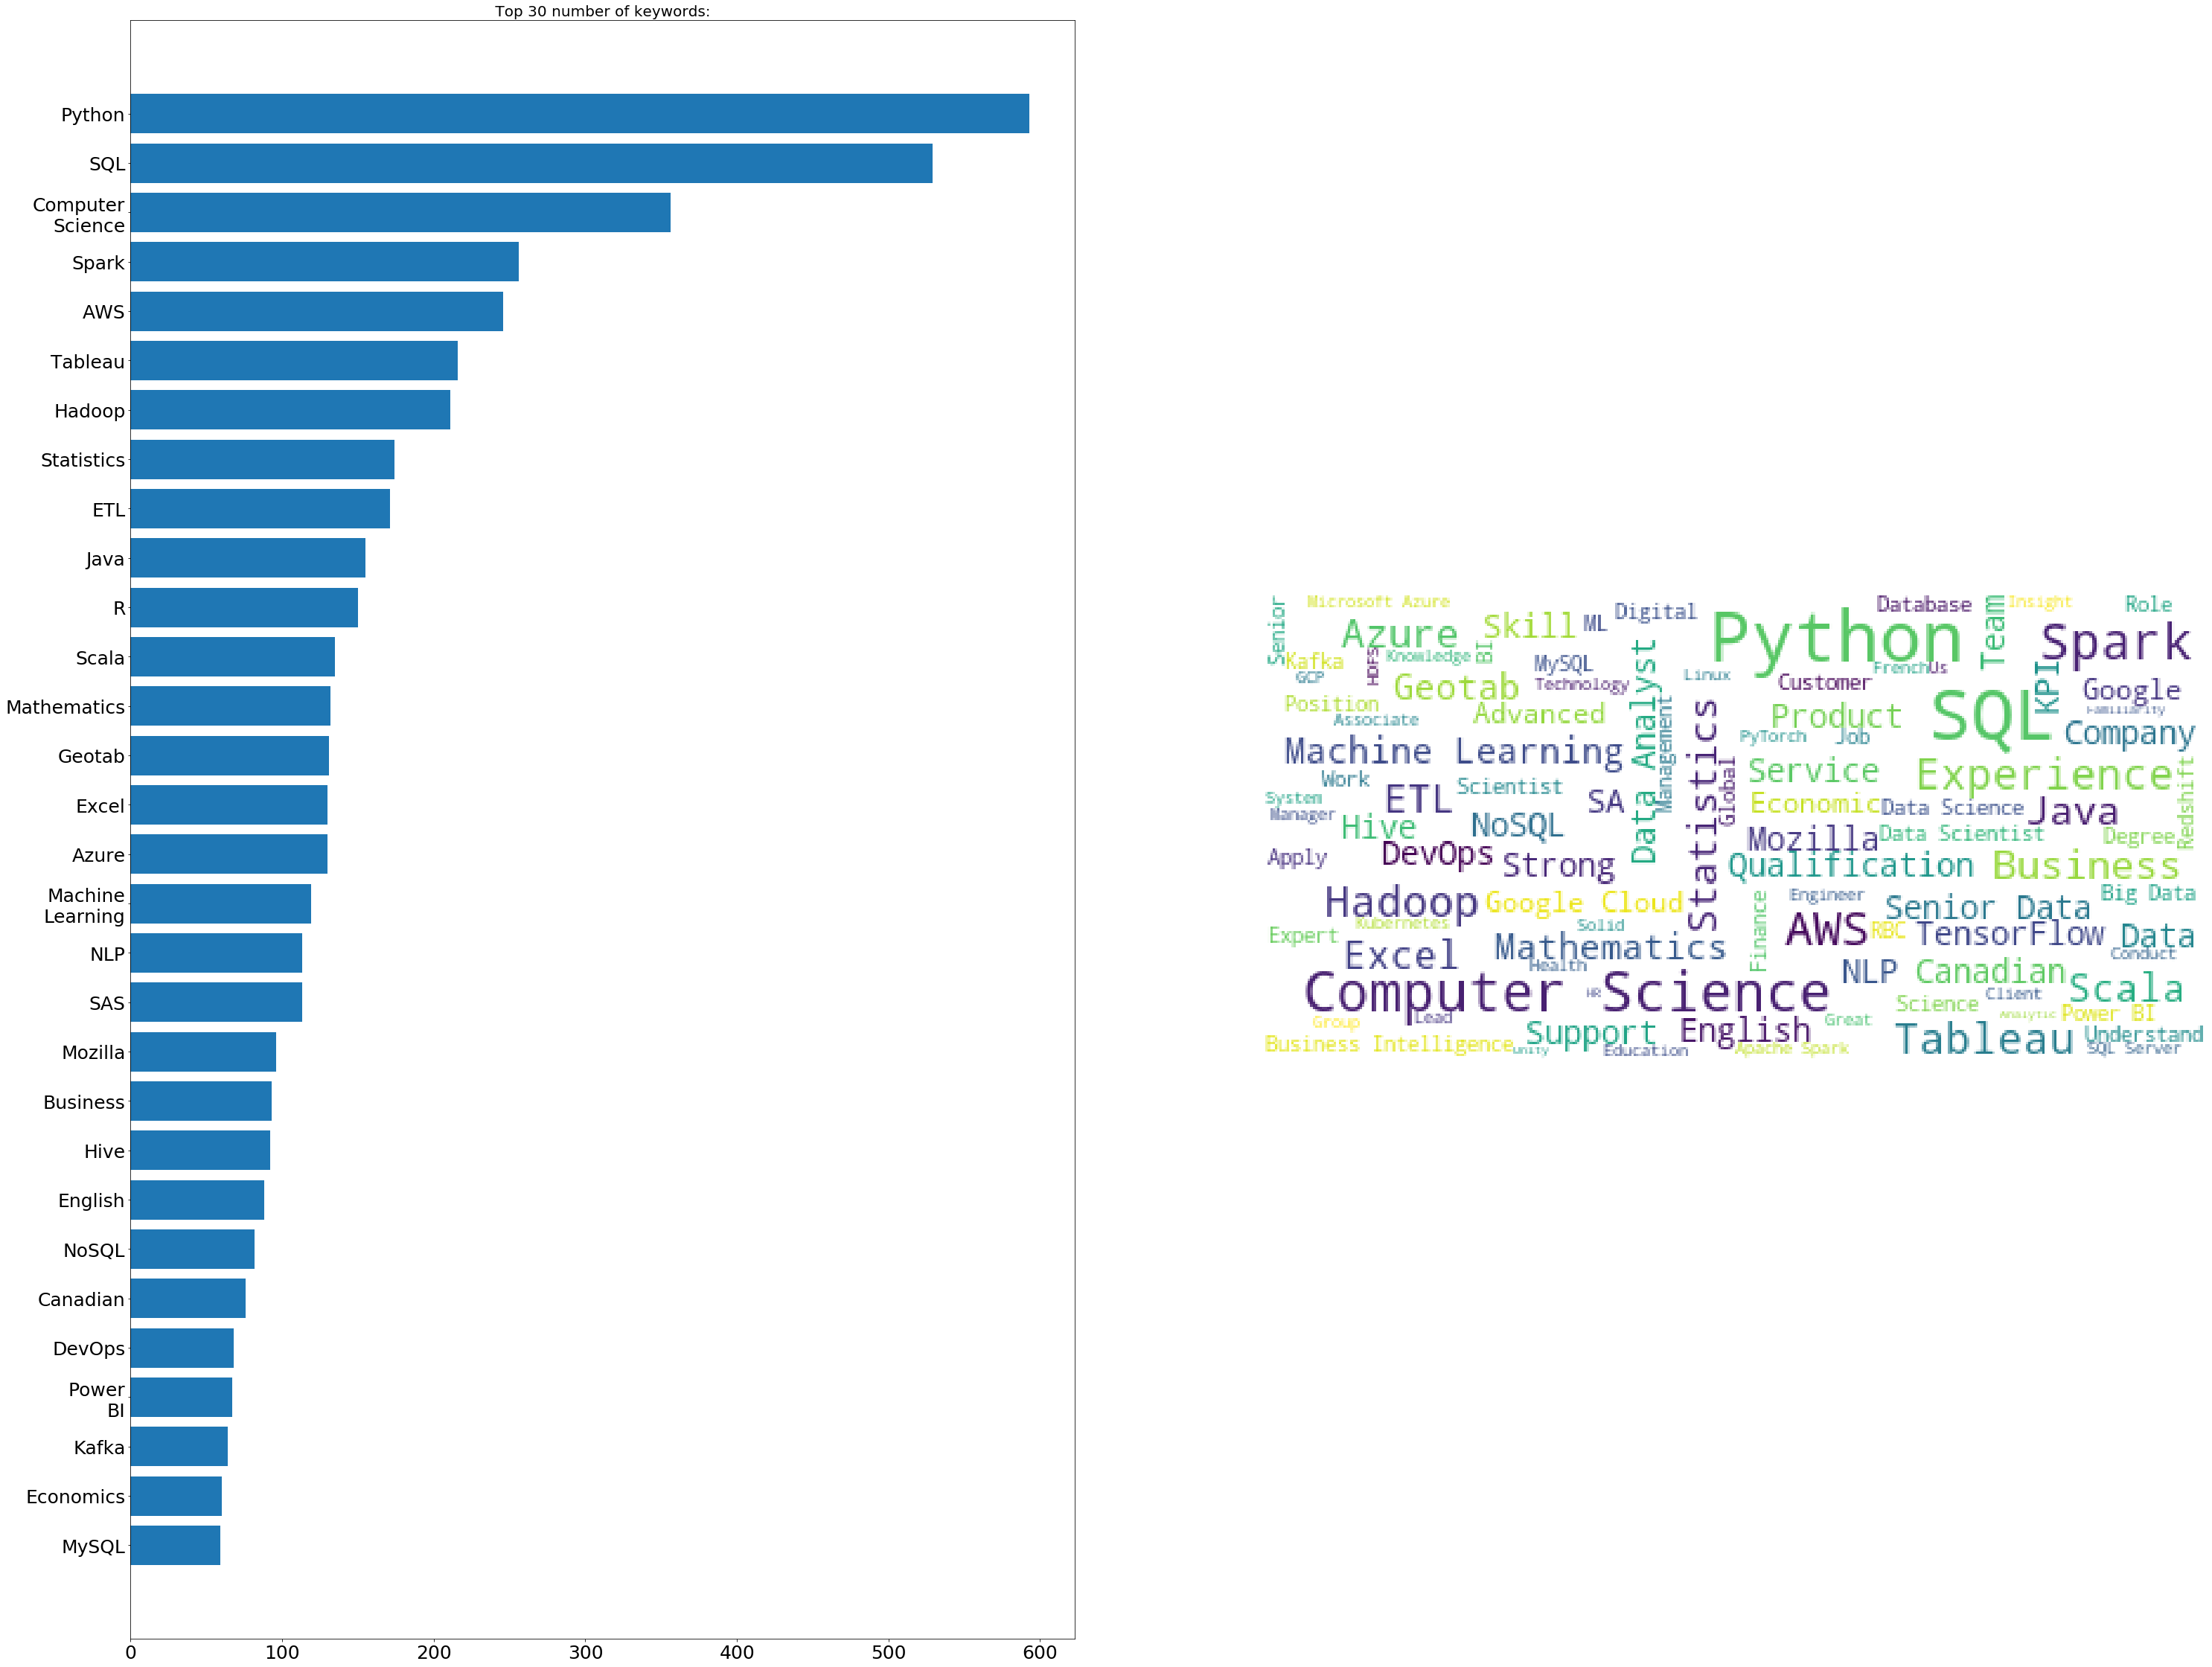

In [29]:
# Keywords of data scientist in Canada
country, title = 'Canada', 'data scientist'
print('- {} keywords in {}'.format(title, country))
# filter with stop words
stop_words = ['Experience', 'Data Scientist', 'Data Analyst', 'Data Science', 'AI', 'Work', 'Develop', 'Toronto',
             'Build', 'Amazon', 'Analytics', 'Analyze', 'Build', 'Nous', 'University', 'API', 'Perform', 'School',
             'Skills', 'Expérience', 'Participate', 'Identify', 'Microsoft', 'IBM', 'Oracle', 'Key', 'Maintain',
             'Loblaw', 'SAP', 'Le', 'Master', 'Montreal', 'Contribute', 'Vous', 'Machine', 'US', 'Technology',
             'Technical', 'Partner', 'Data', 'Analyst', 'Bachelor', 'Collaborate']
entities = remove_words(entities_dt[(country, title)], stop_words)

set_plot(xs=25, ys=25)
fig, axs = plt.subplots(1, 2, figsize=(50,40))
plt.subplots_adjust(wspace=0.2)
draw_bar(entities, axs[0], top=30)
draw_cloud(entities, axs[1])

- data analyst keywords in Canada
- Total number of keywords: 9708


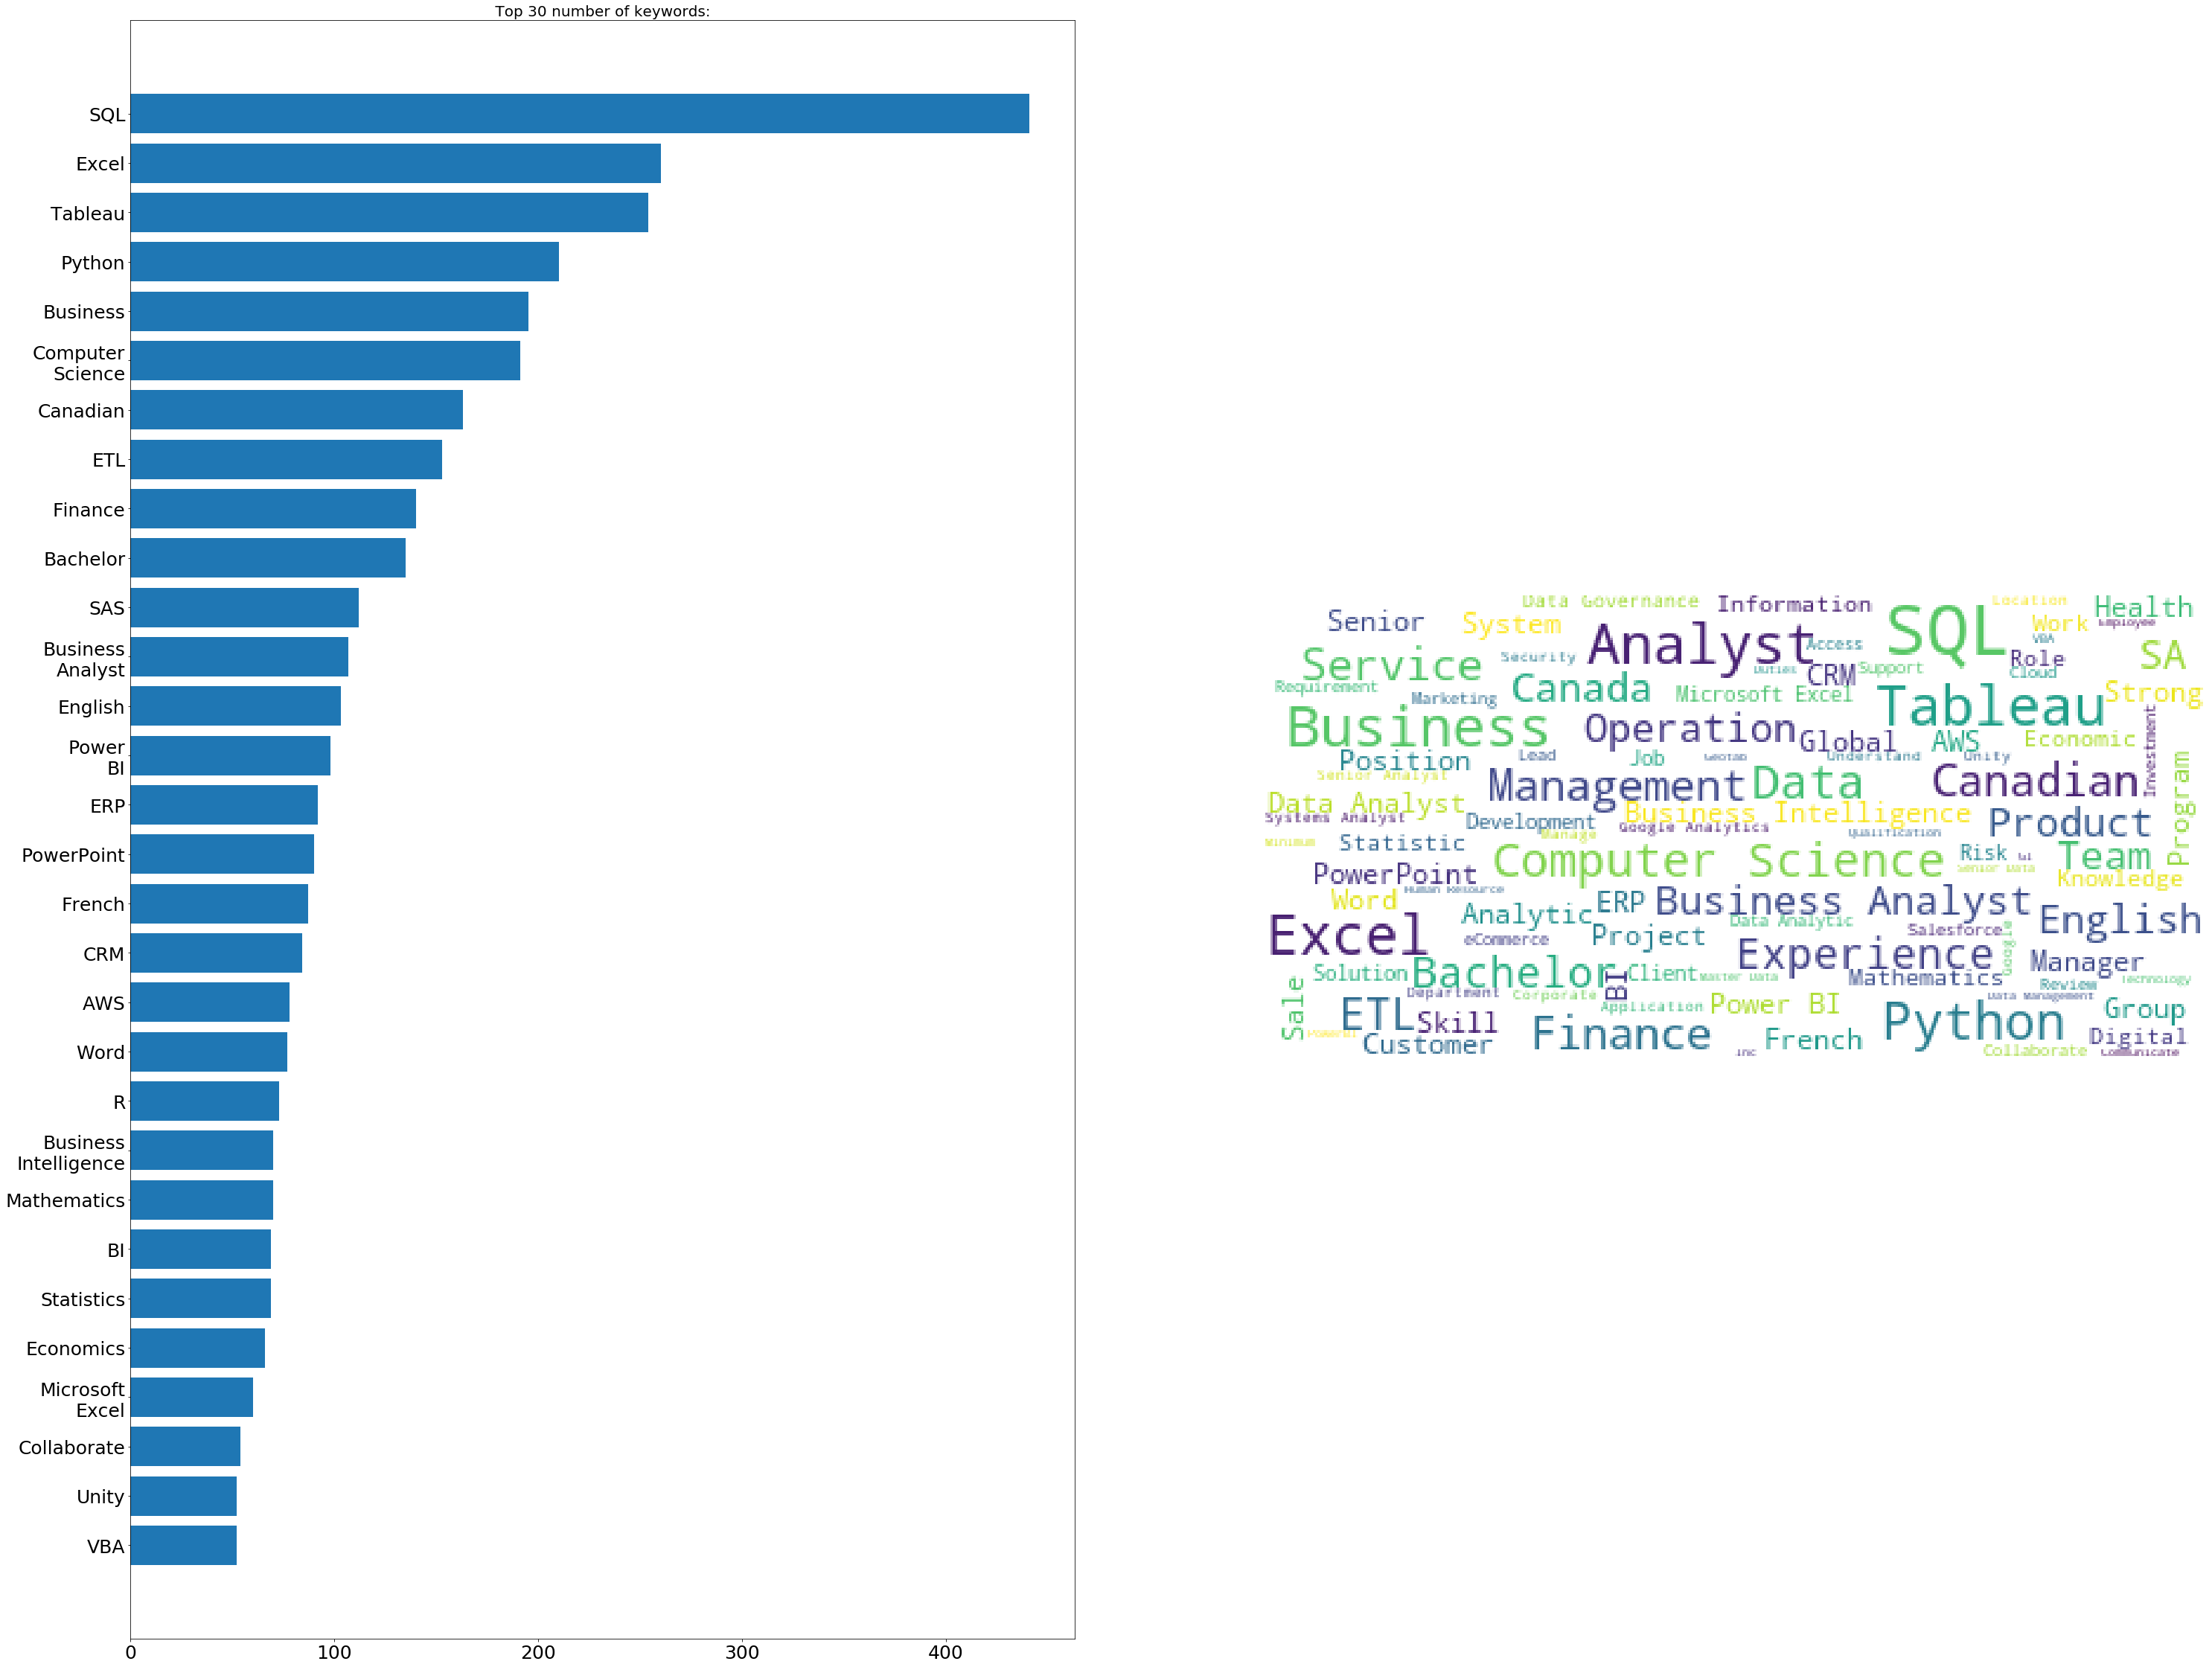

In [14]:
# Keywords of data analyst in Canada
country, title = 'Canada', 'data analyst'
print('- {} keywords in {}'.format(title, country))
# filter with stop words
stop_words = ['Experience', 'Data Scientist', 'Data Analyst', 'Data Science', 'AI', 'Work', 'Develop', 'Toronto',
             'Build', 'Amazon', 'Analytics', 'Analyze', 'Build', 'Nous', 'University', 'API', 'Perform', 'School',
             'Skills', 'Expérience', 'Participate', 'Identify', 'Microsoft', 'IBM', 'Oracle', 'Key', 'Maintain',
             'Loblaw', 'SAP', 'Le', 'Master', 'Montreal', 'Contribute', 'Vous', 'Machine', 'US', 'Technology',
             'Technical', 'Partner', 'Data', 'Analyst', 'Assist', 'Support', 'Provide', 'KPIs', 'Company', 'Ensure',
             'Conduct', 'North America', 'HR', 'Degree', 'Great', 'KPI', 'NTT', 'Advanced']
entities = remove_words(entities_dt[(country, title)], stop_words)

set_plot(xs=25, ys=25)
fig, axs = plt.subplots(1, 2, figsize=(50,40))
plt.subplots_adjust(wspace=0.2)
draw_bar(entities, axs[0], top=30)
draw_cloud(entities, axs[1])

- data engineer keywords in Canada
- Total number of keywords: 8020


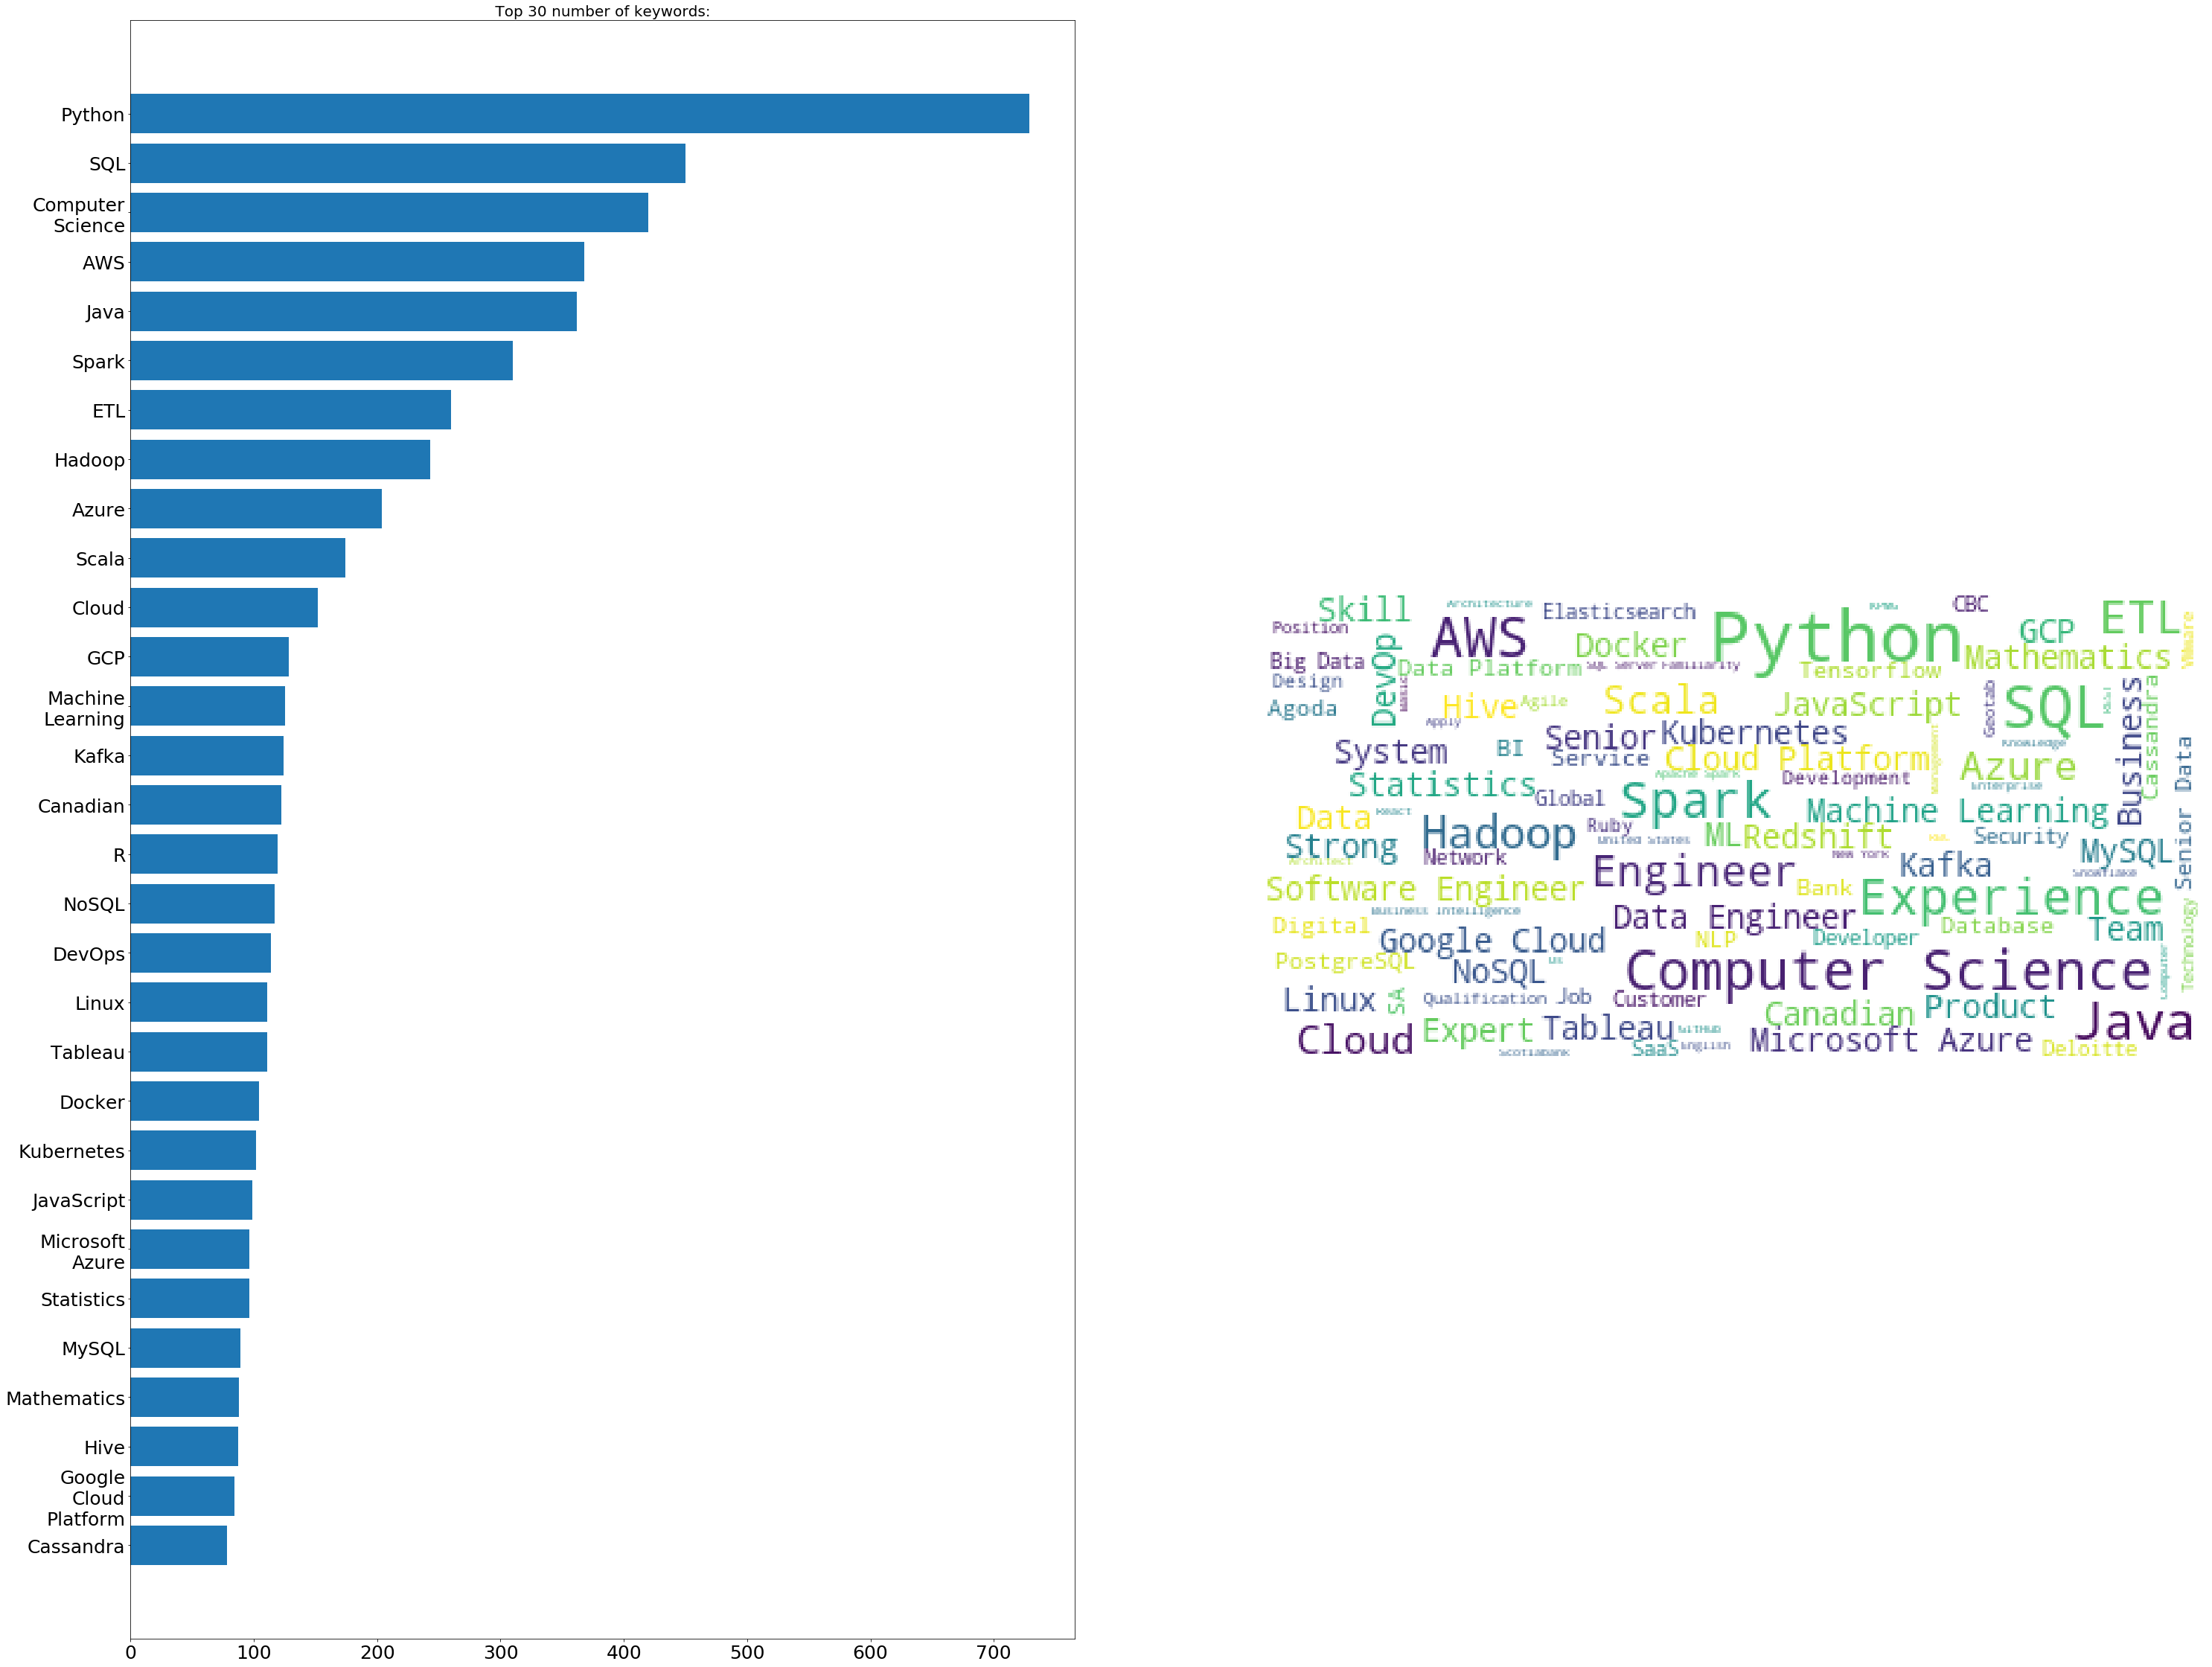

In [31]:
# Keywords of data engineer in Canada
country, title = 'Canada', 'data engineer'
print('- {} keywords in {}'.format(title, country))
# filter with stop words
stop_words = ['Experience', 'Data Scientist', 'Data Analyst', 'Data Science', 'AI', 'Work', 'Develop', 'Toronto',
             'Build', 'Amazon', 'Analytics', 'Analyze', 'Build', 'Nous', 'University', 'API', 'Perform', 'School',
             'Skills', 'Expérience', 'Participate', 'Identify', 'Microsoft', 'IBM', 'Oracle', 'Key', 'Maintain',
             'Loblaw', 'SAP', 'Le', 'Master', 'Montreal', 'Contribute', 'Vous', 'Machine', 'US', 'Technology',
             'Technical', 'Partner', 'Data', 'Analyst', 'Assist', 'Support', 'Provide', 'KPIs', 'Company', 'Ensure',
             'Conduct', 'North America', 'HR', 'Degree', 'Great', 'KPI', 'NTT', 'Advanced', 'Data Engineer',
             'Pythian', 'Google', 'Elastic', 'Solid', 'APIs', 'Platform', 'Software', 'Skill', 'Role', 'Bachelor',
             'Collaborate']
entities = remove_words(entities_dt[(country, title)], stop_words)

set_plot(xs=25, ys=25)
fig, axs = plt.subplots(1, 2, figsize=(50,40))
plt.subplots_adjust(wspace=0.2)
draw_bar(entities, axs[0], top=30)
draw_cloud(entities, axs[1])

- data scientist keywords in United States
- Total number of keywords: 8561


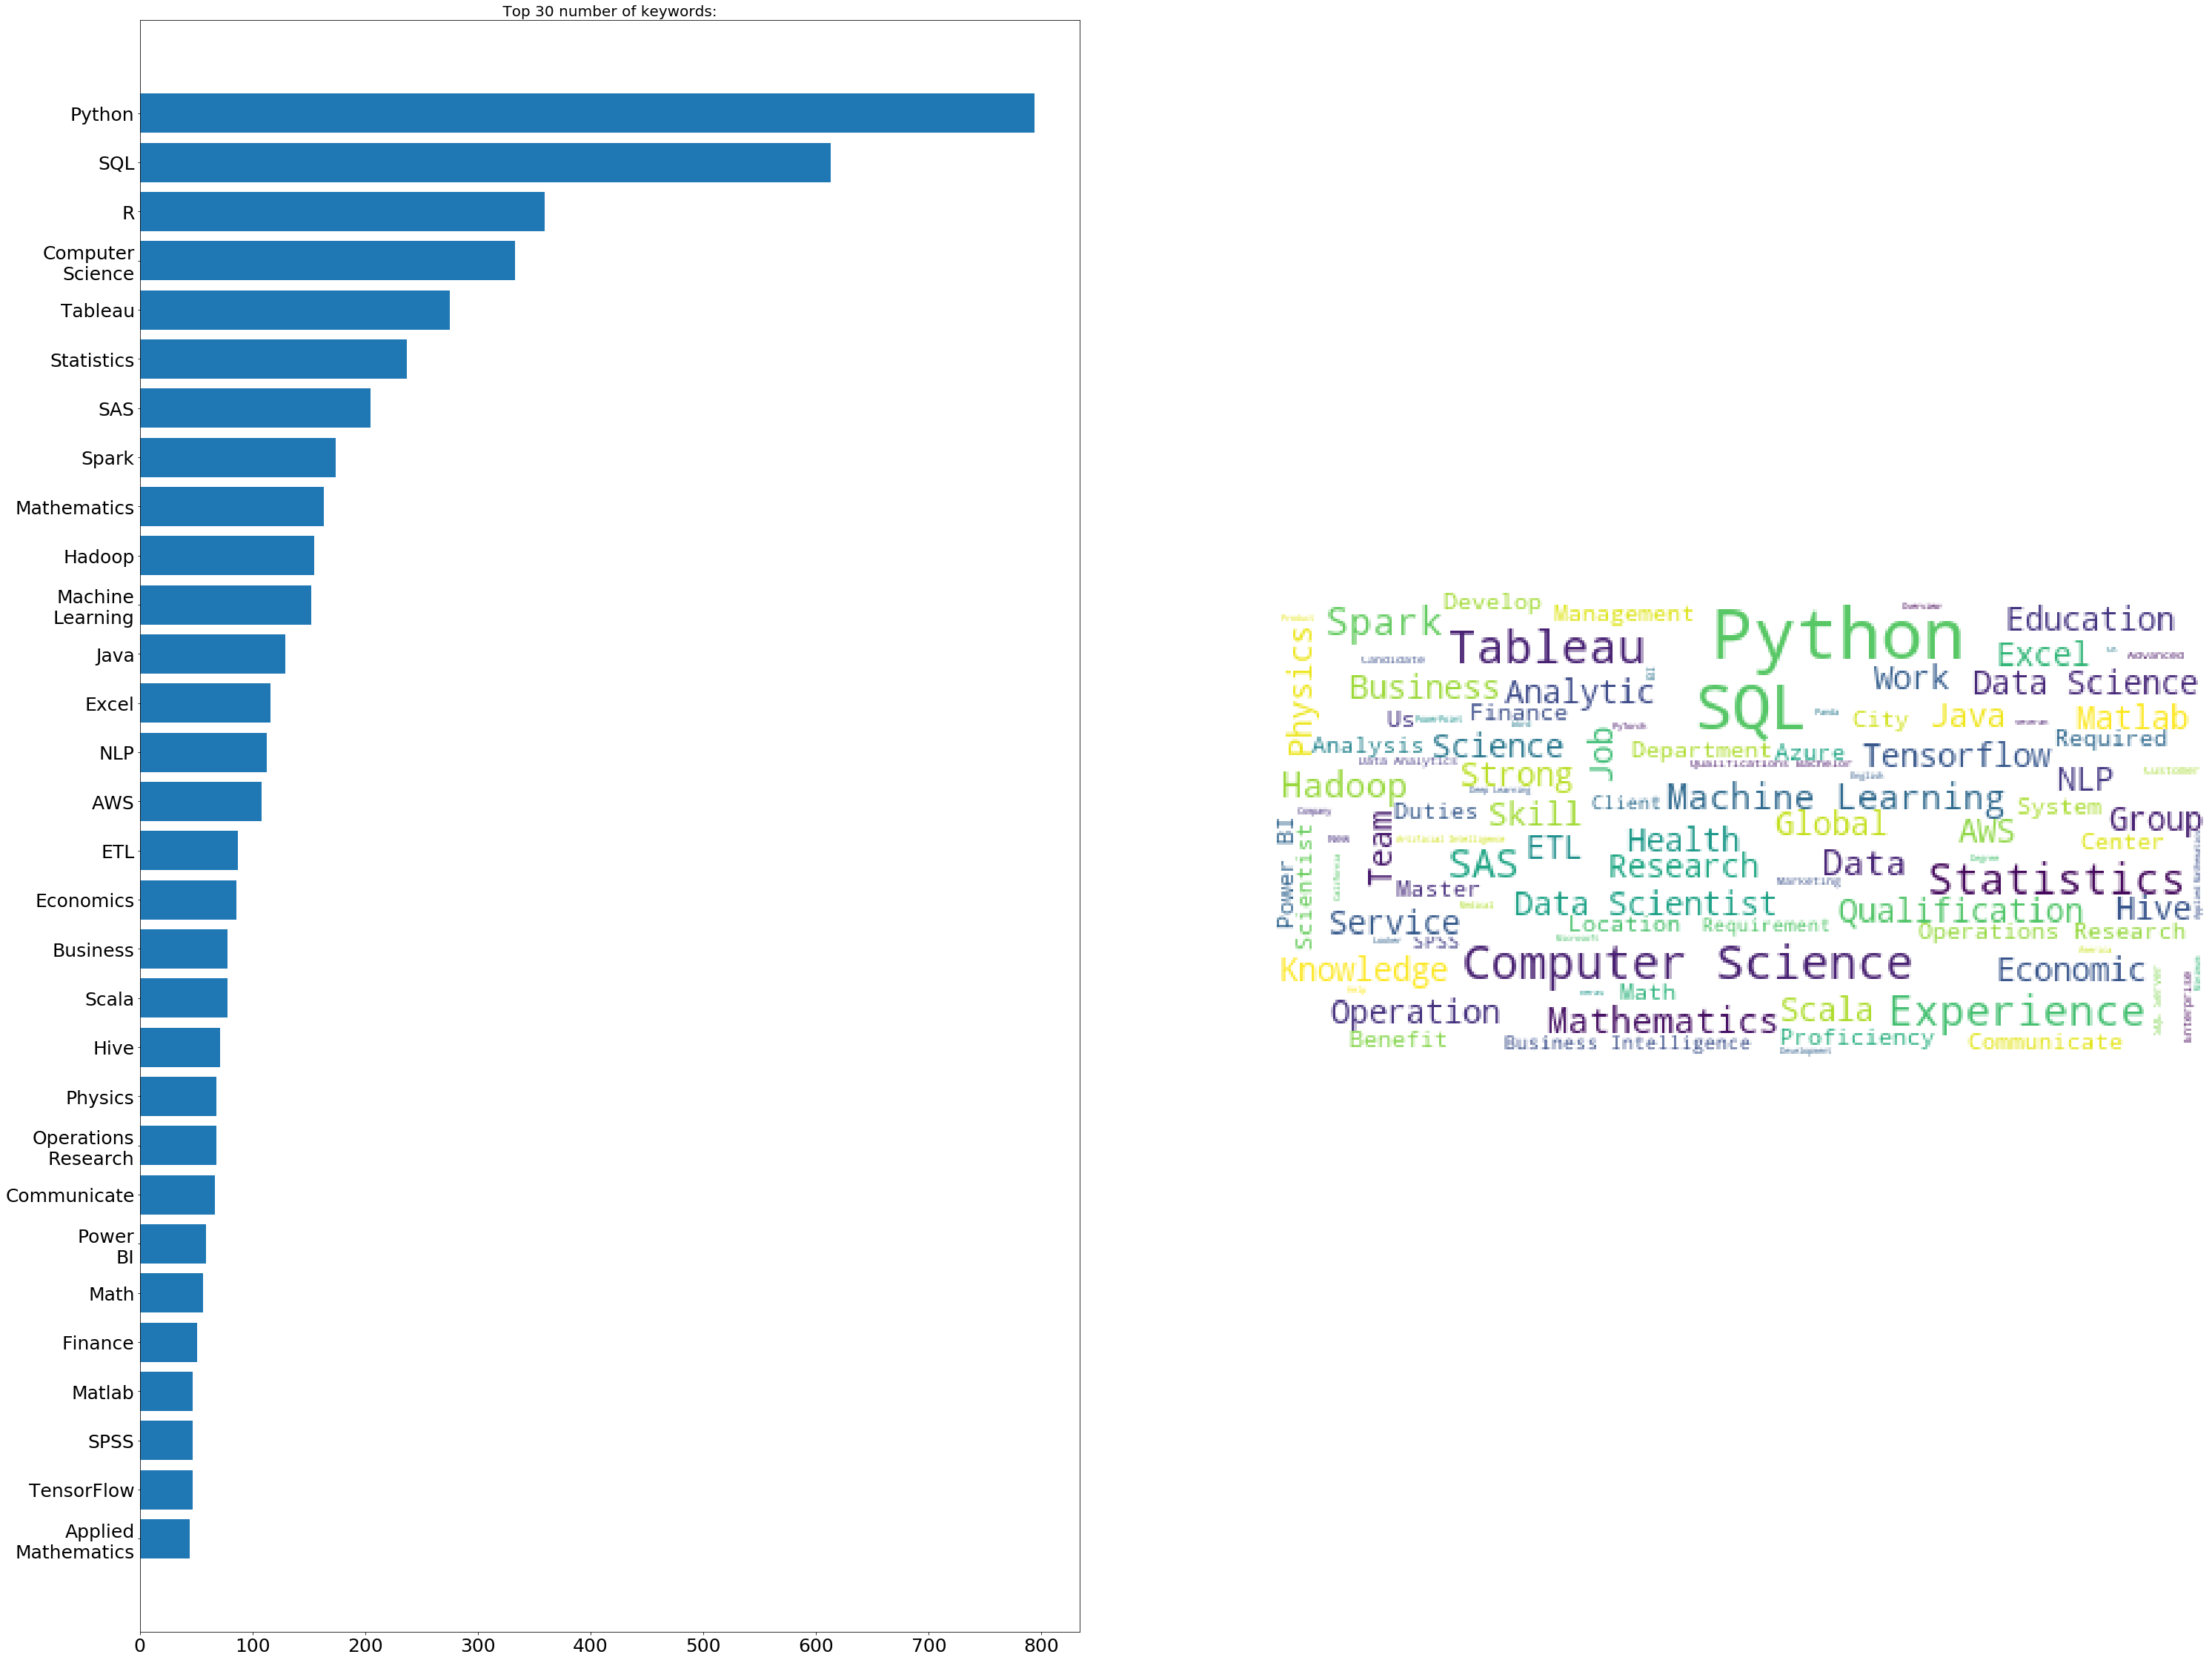

In [39]:
# Keywords of data scientist in United States
country, title = 'United States', 'data scientist'
print('- {} keywords in {}'.format(title, country))
# filter with stop words
stop_words = ['Experience', 'Data Scientist', 'Data Analyst', 'Data Science', 'AI', 'Work', 'Develop', 'Toronto',
             'Build', 'Amazon', 'Analytics', 'Analyze', 'Build', 'Nous', 'University', 'API', 'Perform', 'School',
             'Skills', 'Expérience', 'Participate', 'Identify', 'Microsoft', 'IBM', 'Oracle', 'Key', 'Maintain',
             'Loblaw', 'SAP', 'Le', 'Master', 'Montreal', 'Contribute', 'Vous', 'Machine', 'US', 'Technology',
             'Technical', 'Partner', 'Data', 'Analyst', 'Assist', 'Support', 'Provide', 'KPIs', 'Company', 'Ensure',
             'Conduct', 'North America', 'HR', 'Degree', 'Great', 'KPI', 'NTT', 'Advanced', 'Data Engineer',
             'Pythian', 'Google', 'Elastic', 'Solid', 'APIs', 'Platform', 'Software', 'Skill', 'Role', 'United States',
             'Apply', 'Position', 'Product', 'Expert', 'ML', 'Familiarity', 'New York', 'Design', 'PayPal', 'Use', 
             'EEO', 'U.S.', 'Bachelor', 'Collaborate', 'Washington', 'Minimum', 'LinkedIn', 'Basic', 'San Francisco']
entities = remove_words(entities_dt[(country, title)], stop_words)

set_plot(xs=25, ys=25)
fig, axs = plt.subplots(1, 2, figsize=(50,40))
plt.subplots_adjust(wspace=0.2)
draw_bar(entities, axs[0], top=30)
draw_cloud(entities, axs[1])

- data analyst keywords in United States
- Total number of keywords: 9546


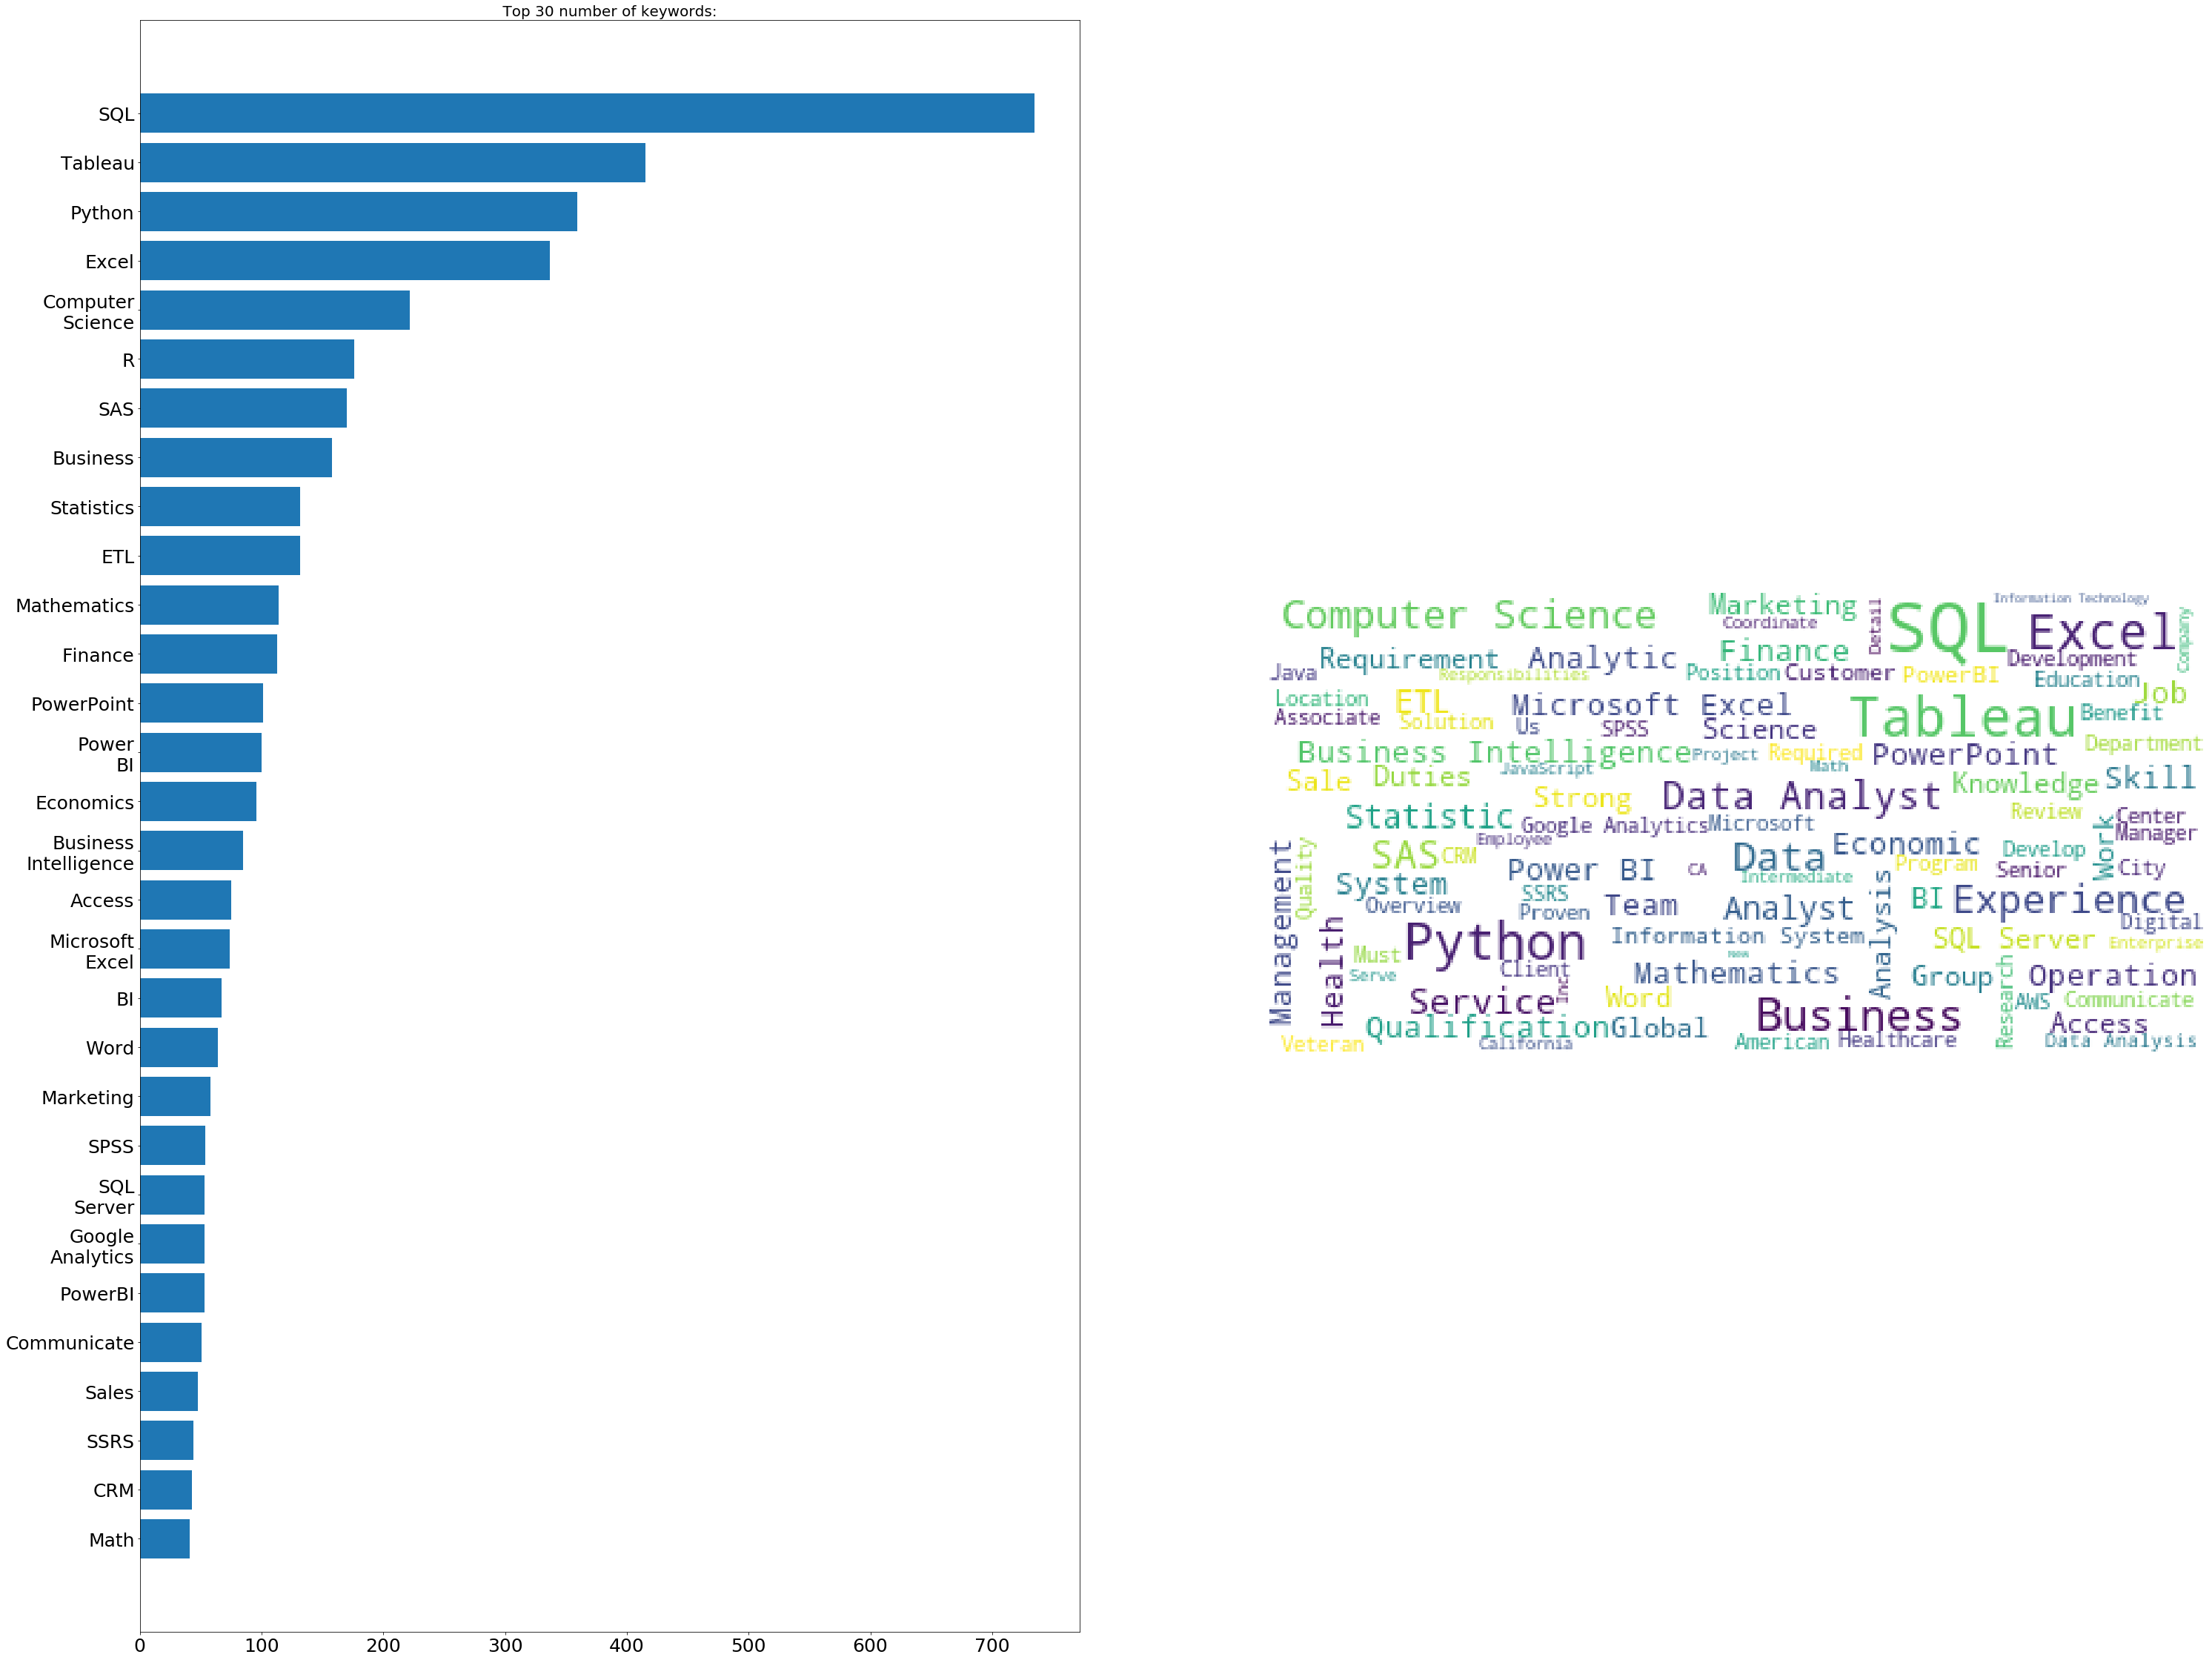

In [43]:
# Keywords of data analyst in United States
country, title = 'United States', 'data analyst'
print('- {} keywords in {}'.format(title, country))
# filter with stop words
stop_words = ['Experience', 'Data Scientist', 'Data Analyst', 'Data Analytics','Data Science', 'AI', 'Work', 'Develop', 'Toronto',
             'Build', 'Amazon', 'Analytics', 'Analyze', 'Build', 'Nous', 'University', 'API', 'Perform', 'School',
             'Skills', 'Expérience', 'Participate', 'Identify', 'Microsoft', 'IBM', 'Oracle', 'Key', 'Maintain',
             'Loblaw', 'SAP', 'Le', 'Master', 'Montreal', 'Contribute', 'Vous', 'Machine', 'US', 'Technology',
             'Technical', 'Partner', 'Data', 'Analyst', 'Assist', 'Support', 'Provide', 'KPIs', 'Company', 'Ensure',
             'Conduct', 'North America', 'HR', 'Degree', 'Great', 'KPI', 'NTT', 'Advanced', 'Data Engineer',
             'Pythian', 'Google', 'Elastic', 'Solid', 'APIs', 'Platform', 'Software', 'Skill', 'Role', 'United States',
             'Apply', 'Position', 'Product', 'Expert', 'ML', 'Familiarity', 'New York', 'Design', 'PayPal', 'Use', 
             'EEO', 'Looker', 'Education', 'U.S.', 'America', 'Minimum', 'Salesforce', 'Department', 'Highly',
             'U.S.', 'Bachelor', 'Collaborate', 'Washington', 'Minimum', 'LinkedIn', 'Basic', 'San Francisco',
             'Operations', 'Qualifications Bachelor']
entities = remove_words(entities_dt[(country, title)], stop_words)

set_plot(xs=25, ys=25)
fig, axs = plt.subplots(1, 2, figsize=(50,40))
plt.subplots_adjust(wspace=0.2)
draw_bar(entities, axs[0], top=30)
draw_cloud(entities, axs[1])

- data engineer keywords in United States
- Total number of keywords: 8019


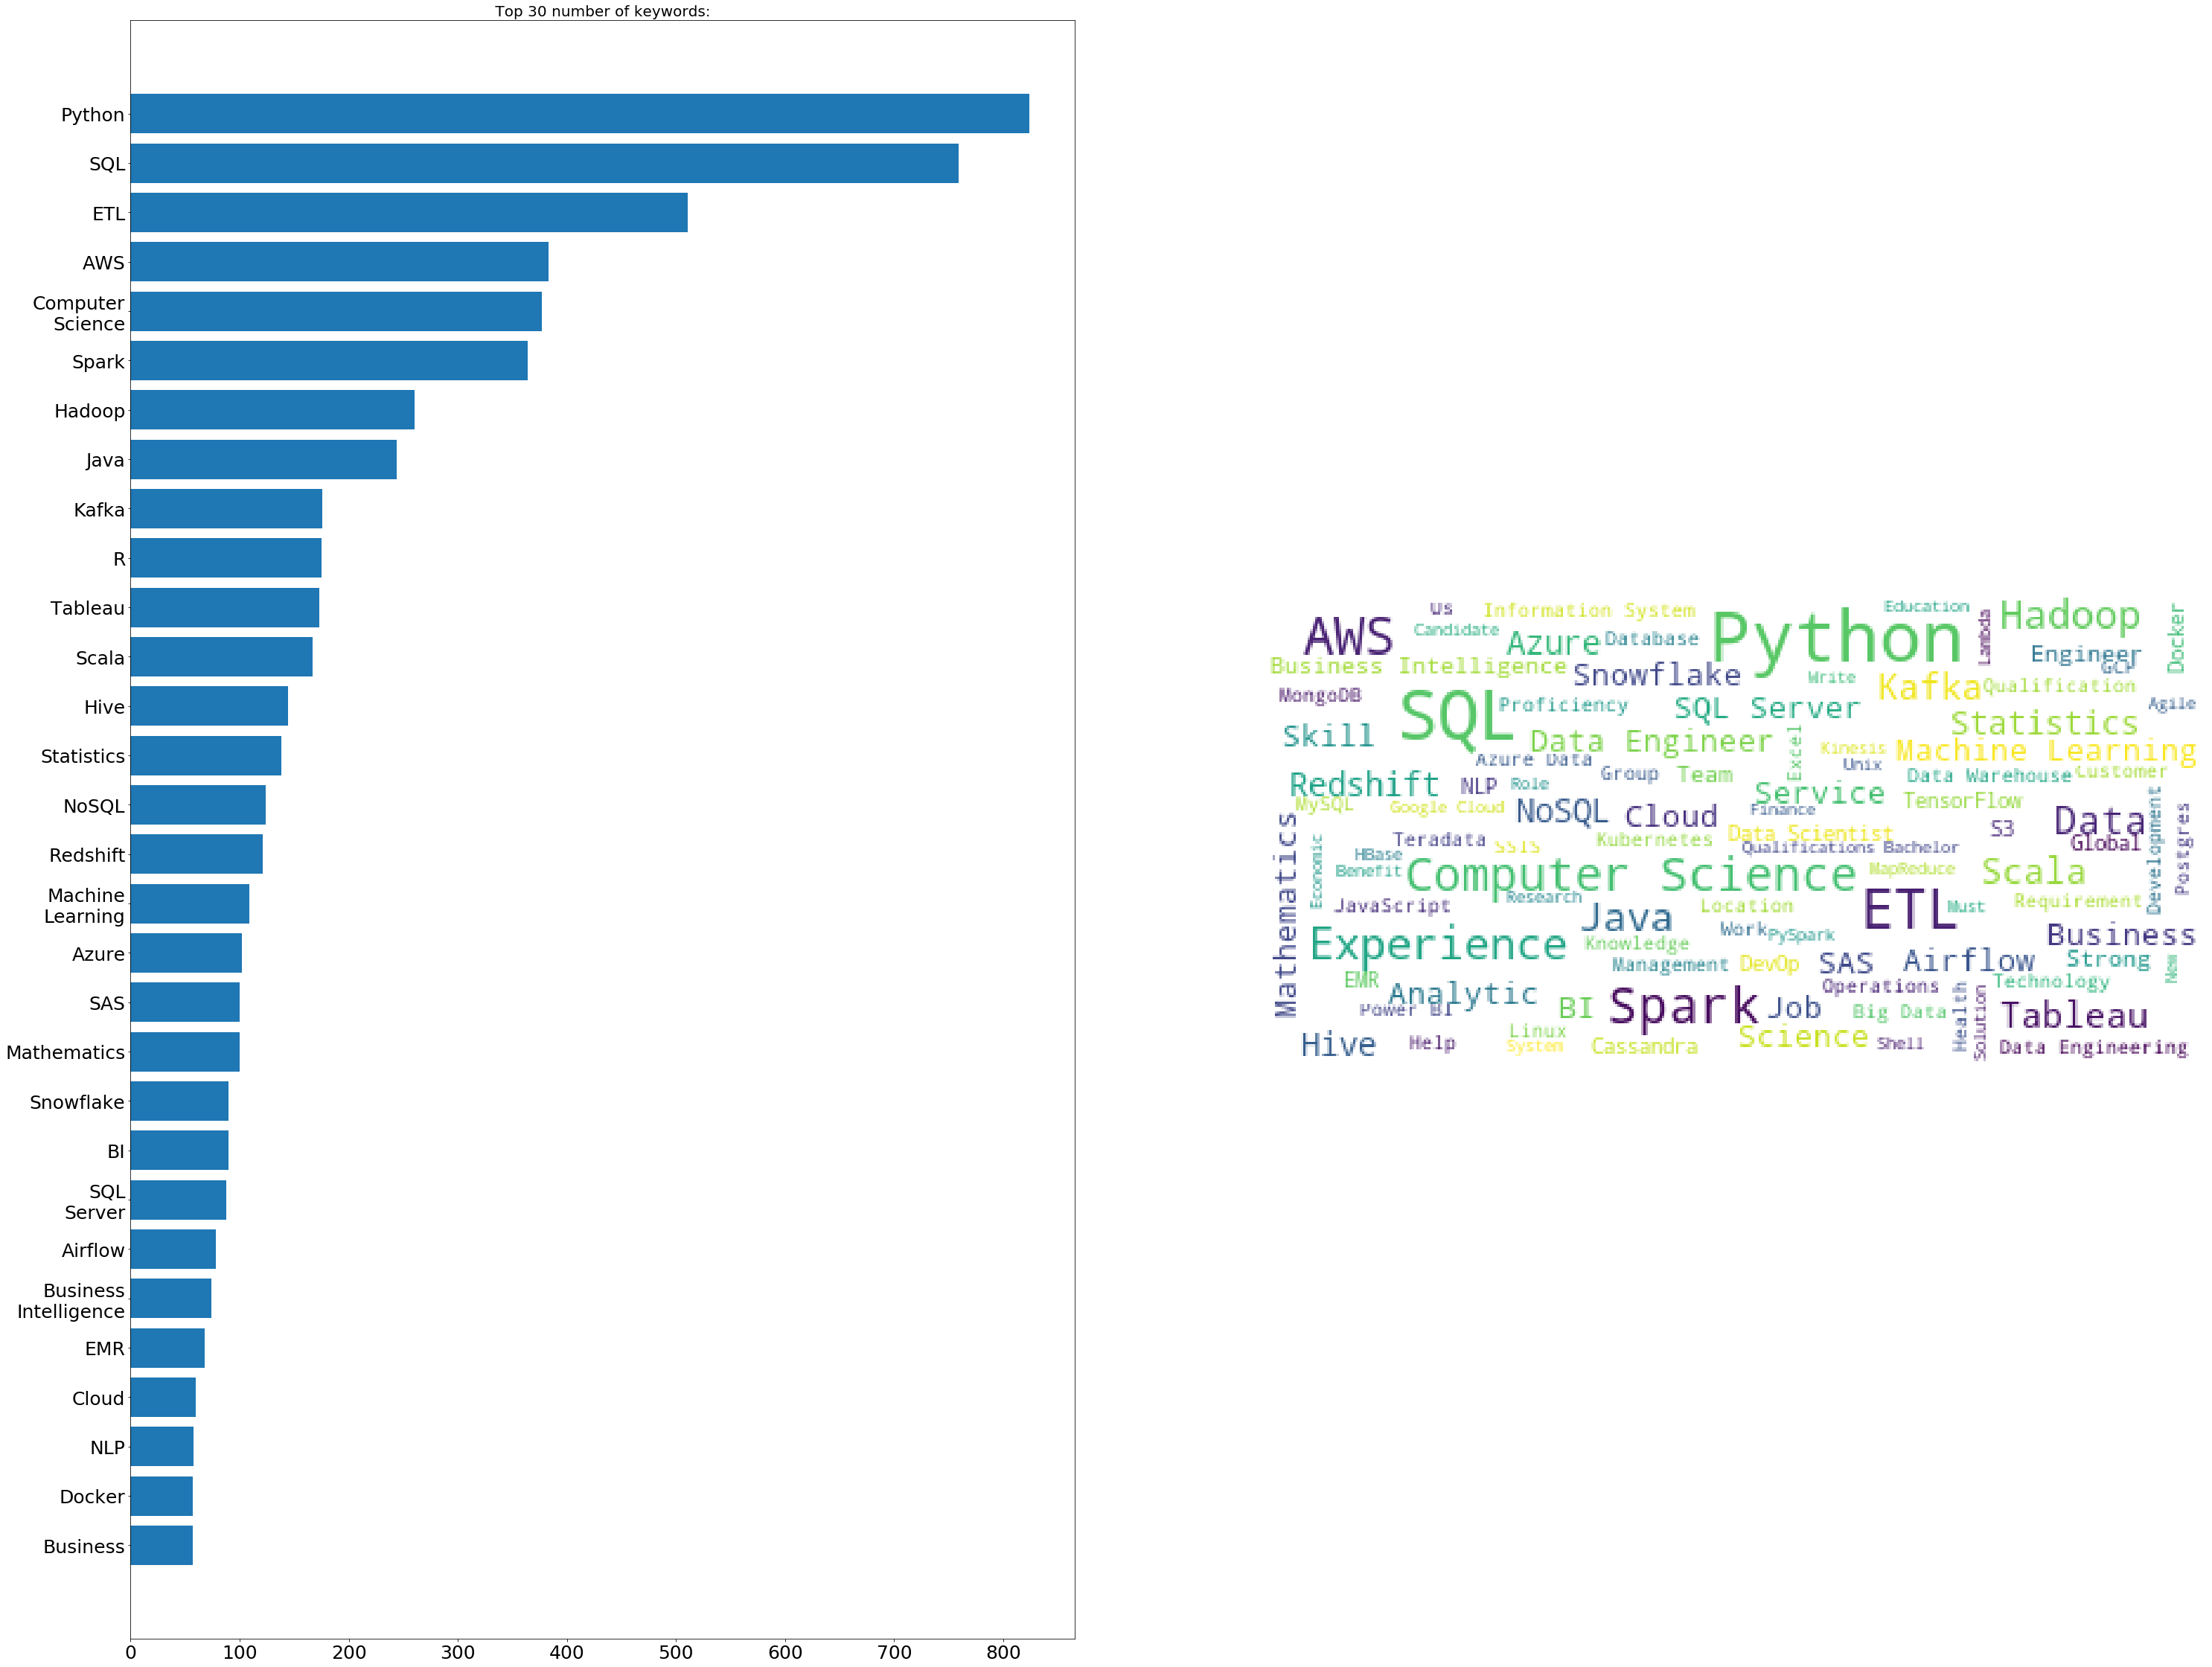

In [44]:
# Keywords of data engineer in United States
country, title = 'United States', 'data engineer'
print('- {} keywords in {}'.format(title, country))
# filter with stop words
stop_words = ['Experience', 'Data Scientist', 'Data Analyst', 'Data Analytics','Data Science', 'AI', 'Work', 'Develop', 'Toronto',
             'Build', 'Amazon', 'Analytics', 'Analyze', 'Build', 'Nous', 'University', 'API', 'Perform', 'School',
             'Skills', 'Expérience', 'Participate', 'Identify', 'Microsoft', 'IBM', 'Oracle', 'Key', 'Maintain',
             'Loblaw', 'SAP', 'Le', 'Master', 'Montreal', 'Contribute', 'Vous', 'Machine', 'US', 'Technology',
             'Technical', 'Partner', 'Data', 'Analyst', 'Assist', 'Support', 'Provide', 'KPIs', 'Company', 'Ensure',
             'Conduct', 'North America', 'HR', 'Degree', 'Great', 'KPI', 'NTT', 'Advanced', 'Data Engineer',
             'Pythian', 'Google', 'Elastic', 'Solid', 'APIs', 'Platform', 'Software', 'Skill', 'Role', 'United States',
             'Apply', 'Position', 'Product', 'Expert', 'ML', 'Familiarity', 'New York', 'Design', 'PayPal', 'Use', 
             'EEO', 'Looker', 'Education', 'U.S.', 'America', 'Minimum', 'Salesforce', 'Department', 'Highly','CA',
             'Informatica','U.S.', 'Bachelor', 'Collaborate', 'Washington', 'Minimum', 'LinkedIn', 'Basic', 
              'San Francisco']
entities = remove_words(entities_dt[(country, title)], stop_words)

set_plot(xs=25, ys=25)
fig, axs = plt.subplots(1, 2, figsize=(50,40))
plt.subplots_adjust(wspace=0.2)
draw_bar(entities, axs[0], top=30)
draw_cloud(entities, axs[1])

## <div id='indeed'>2. Indeed</div>
### <div id='ind1'>2.1 Overall Description</div>
In this section, we are going to analyze the job postings in indeed.

In [19]:
# load data
fname = 'https://raw.githubusercontent.com/liuweilin17/mie1624/master/project/data/indeed_job_dataset.csv'
df_indeed = pd.read_csv(fname)

In [20]:
df_indeed.head()

,Unnamed: 0,Job_Title,Link,Queried_Salary,Job_Type,Skill,No_of_Skills,Company,No_of_Reviews,No_of_Stars,...,MD,DC,NC,Other_states,Consulting and Business Services,Internet and Software,Banks and Financial Services,Health Care,Insurance,Other_industries
0,0,Data Scientist,https://www.indeed.com/rc/clk?jk=6a105f495c36a...,<80000,data_scientist,"['SAP', 'SQL']",2,Express Scripts,3301.0,3.3,...,0,0,0,1,0,0,0,1,0,0
1,1,Data Scientist,https://www.indeed.com/rc/clk?jk=86afd561ea8c6...,<80000,data_scientist,"['Machine Learning', 'R', 'SAS', 'SQL', 'Python']",5,Money Mart Financial Services,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2,Data Scientist,https://www.indeed.com/rc/clk?jk=e0aad317e6d45...,<80000,data_scientist,"['Data Mining', 'Data Management', 'R', 'SAS',...",9,comScore,62.0,3.5,...,0,0,0,1,0,0,0,0,0,0
3,3,Graduate Studies Program - Data Scientist,https://www.indeed.com/rc/clk?jk=1cfdd9e391a63...,<80000,data_scientist,['Certified Internal Auditor'],1,Central Intelligence Agency,158.0,4.3,...,0,1,0,0,0,0,0,0,0,1
4,4,Data Scientist I,https://www.indeed.com/rc/clk?jk=fec647775a21e...,<80000,data_scientist,"['Statistical Software', 'Time Management', 'R...",7,Federal Reserve Bank of Dallas,495.0,4.1,...,0,0,0,0,0,0,1,0,0,0


In [21]:
df_indeed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5715 entries, 0 to 5714
Data columns (total 43 columns):
Unnamed: 0                          5715 non-null int64
Job_Title                           5715 non-null object
Link                                5715 non-null object
Queried_Salary                      5715 non-null object
Job_Type                            5715 non-null object
Skill                               5483 non-null object
No_of_Skills                        5715 non-null int64
Company                             5611 non-null object
No_of_Reviews                       4753 non-null float64
No_of_Stars                         4753 non-null float64
Date_Since_Posted                   5611 non-null float64
Description                         5413 non-null object
Location                            5463 non-null object
Company_Revenue                     2017 non-null object
Company_Employees                   3199 non-null object
Company_Industry                    3

In [22]:
df_indeed.describe()

,Unnamed: 0,No_of_Skills,No_of_Reviews,No_of_Stars,Date_Since_Posted,python,sql,machine learning,r,hadoop,...,MD,DC,NC,Other_states,Consulting and Business Services,Internet and Software,Banks and Financial Services,Health Care,Insurance,Other_industries
count,5715.000000,5715.000000,4753.000000,4753.000000,5611.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,...,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000
mean,2857.000000,7.803675,4311.389649,3.845613,22.273570,0.581802,0.543132,0.401925,0.390901,0.299913,...,0.029571,0.024497,0.024322,0.283990,0.128259,0.113211,0.080315,0.059318,0.039720,0.248644
std,1649.922725,5.091596,17860.068211,0.409466,10.068934,0.493306,0.498180,0.490330,0.487995,0.458259,...,0.169416,0.154600,0.154060,0.450971,0.334407,0.316878,0.271804,0.236239,0.195318,0.432265
min,0.000000,0.000000,2.000000,1.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1428.500000,4.000000,33.000000,3.700000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2857.000000,7.000000,387.000000,3.900000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4285.500000,11.000000,2581.000000,4.100000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5714.000000,20.000000,157475.000000,5.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### <div id='ind2'>2.2 Data Preprocess</div>
In this section, data cleaning and features are selected.

In [23]:
# Select useful columns
selected_cols = ['Queried_Salary', 'Skill', 'python', 'sql', 'machine learning', 'r', 'hadoop', 'tableau',
                'sas', 'spark', 'java', 'Consulting and Business Services', 'Internet and Software',
                'Banks and Financial Services', 'Health Care', 'Insurance']
df_indeed = df_indeed[selected_cols]
# Drop NaN
print(df_indeed.shape)
df_indeed.dropna(inplace=True)
print(df_indeed.shape)
# Transform Queries
dt = {
    '<80000': 80000,
    '80000-99999': 90000,
    '100000-119999': 110000,
    '120000-139999': 130000,
    '140000-159999': 150000,
    '>160000': 160000
}
df_indeed['Queried_Salary'] = df_indeed['Queried_Salary'].apply(lambda x:dt[x])
print(df_indeed['Queried_Salary'].unique())

(5715, 16)
(5483, 16)
[ 80000  90000 110000 130000 150000 160000]


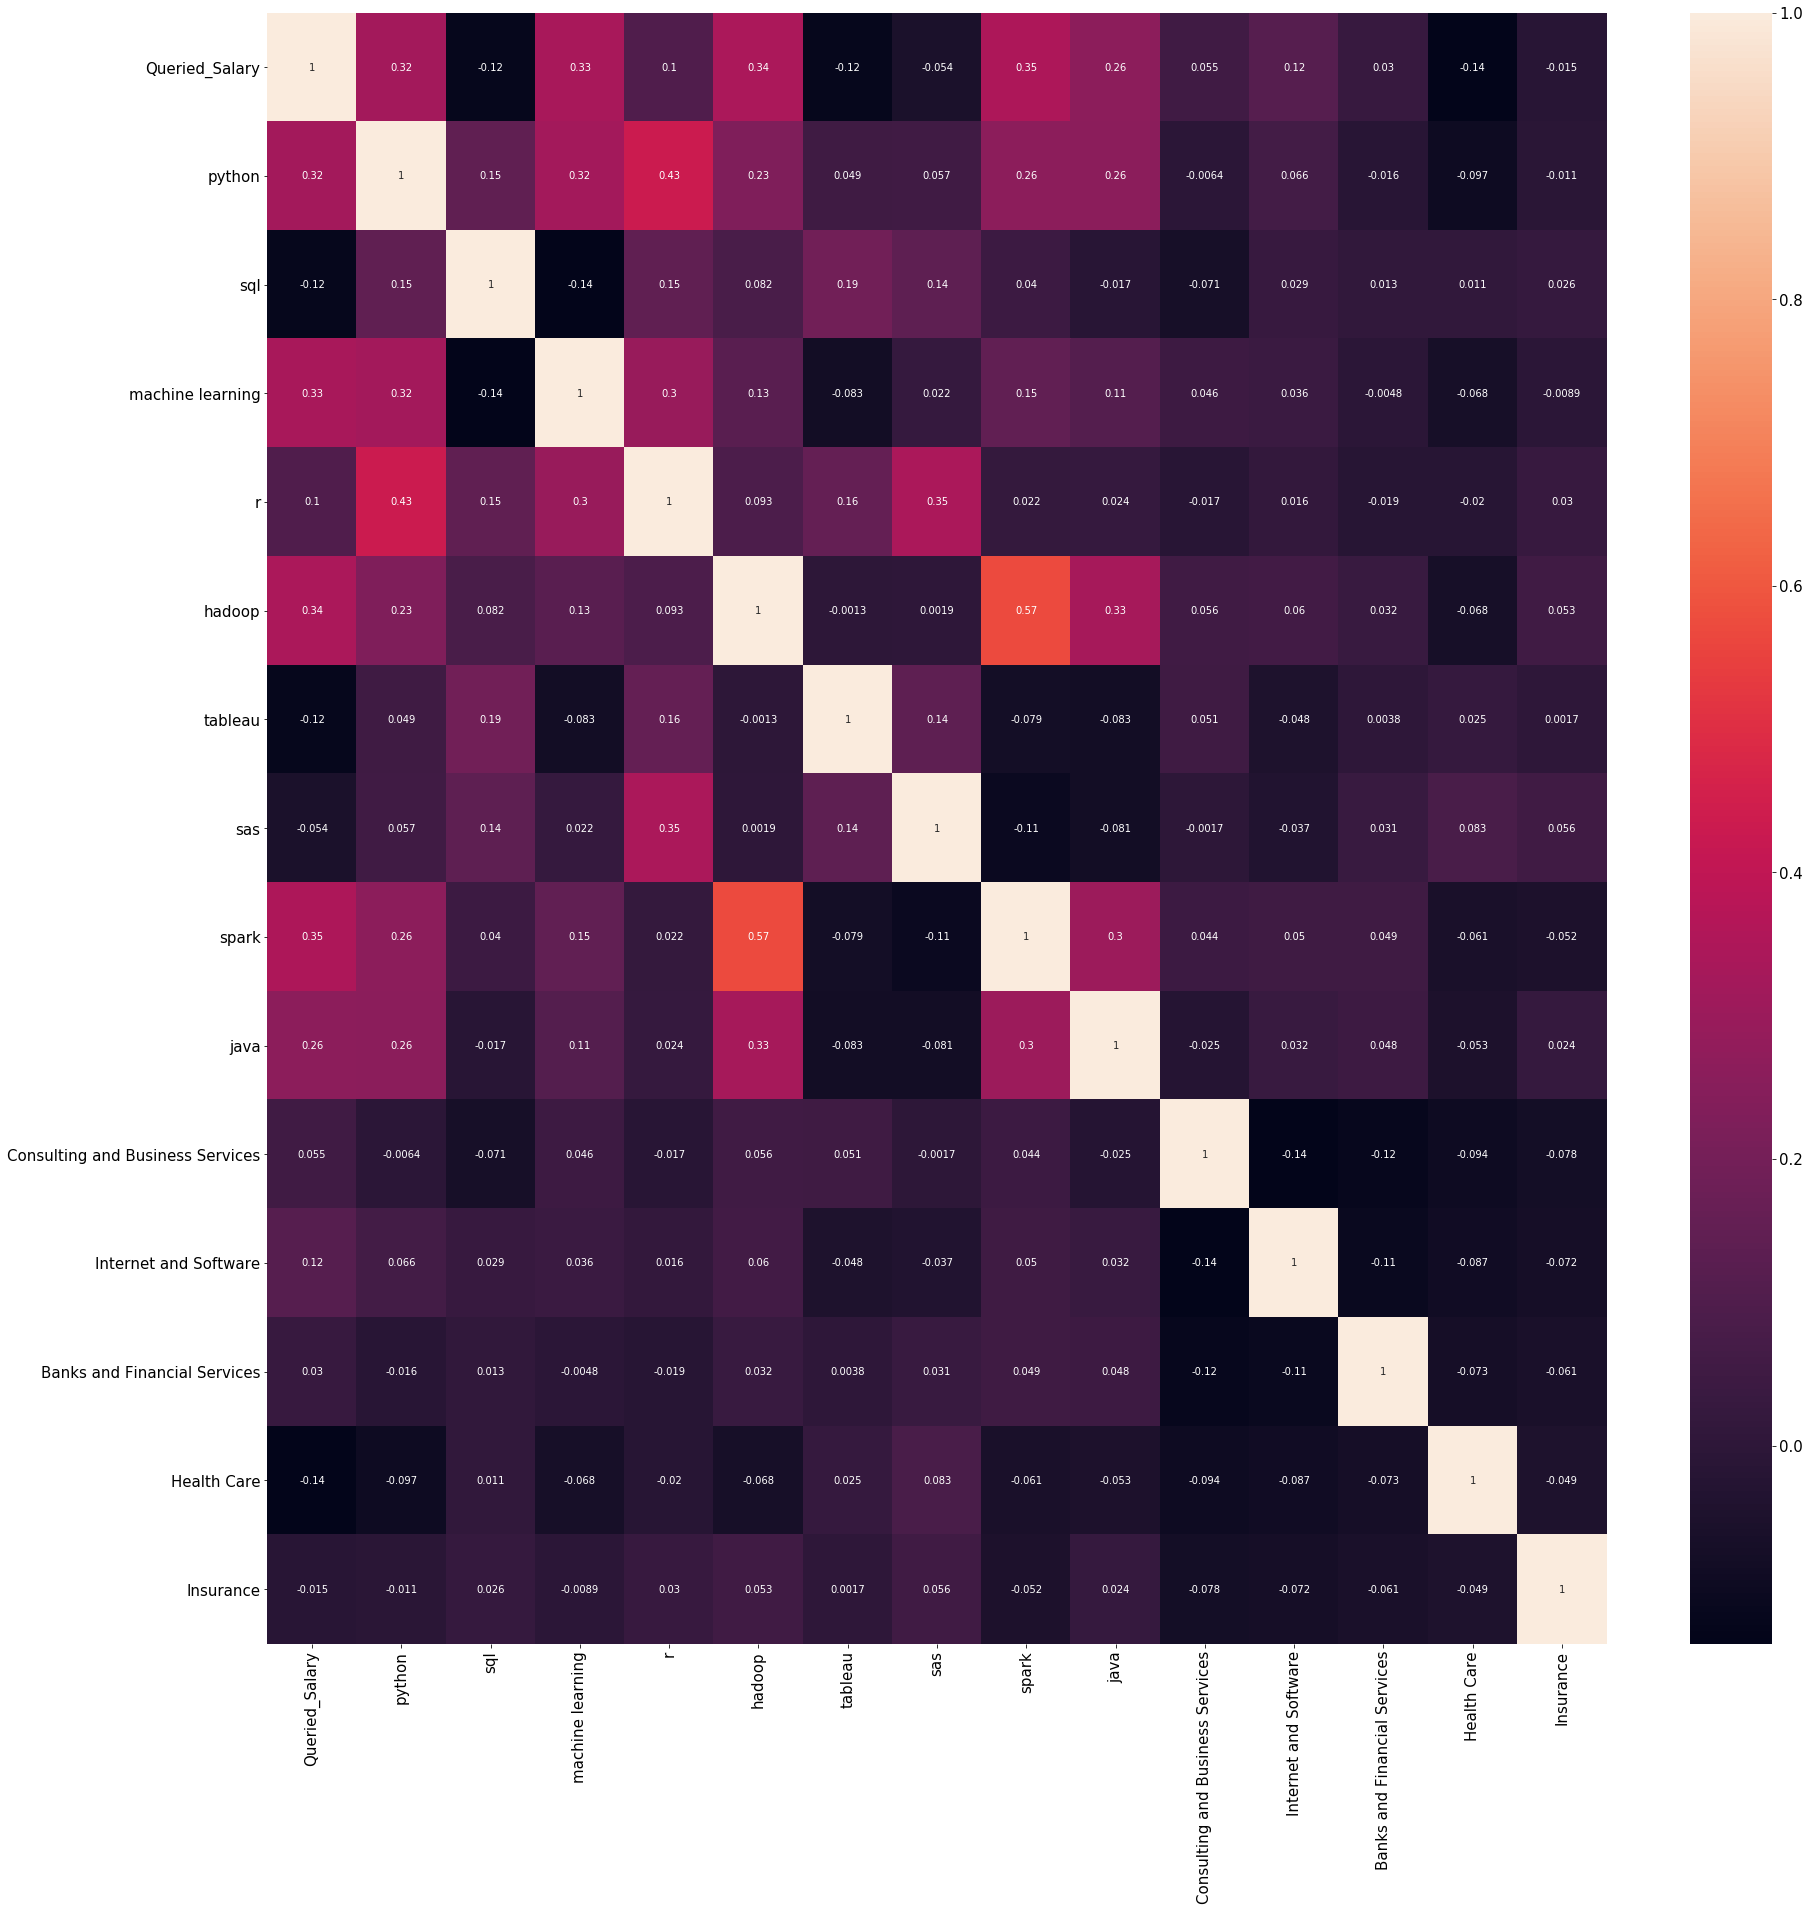

In [24]:
# Plot Correlation Matrix
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
fig, ax = plt.subplots(figsize=(30,30))
ax = sns.heatmap(df_indeed.corr(), annot=True)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

### <div id='ind3'>2.3 Skills vs Salaries</div>
In this section, we tend to find the correlation between Skills and Salaries.

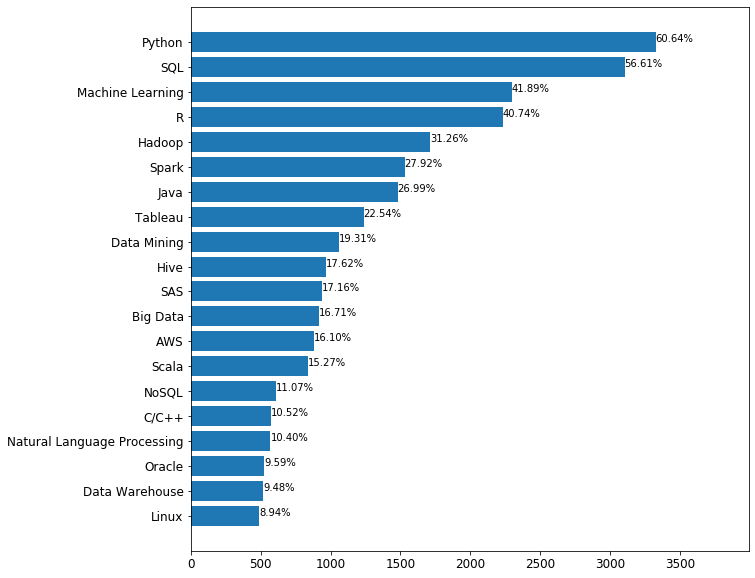

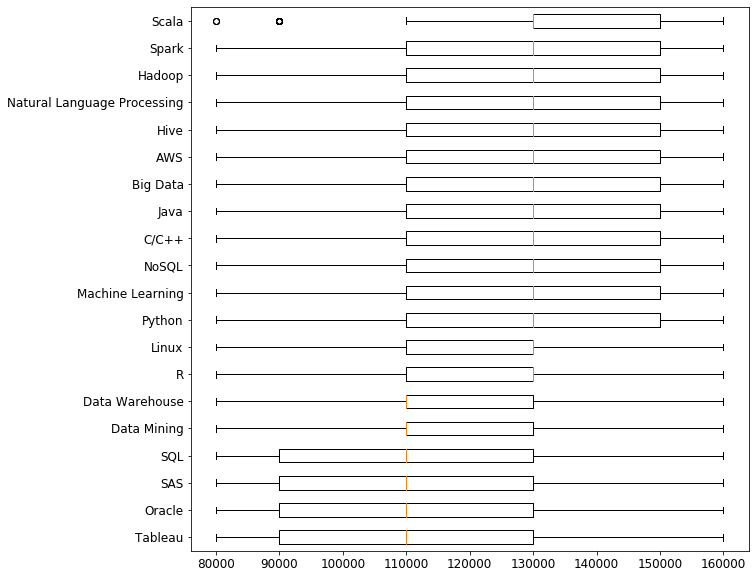

In [25]:
Skill_Salary_dt = collections.defaultdict(list)

def extract_skill(skill):
    skill = skill.strip('[]')
    ret = []
    for sk in skill.split(','):
        ret.append(sk.strip(' \''))
    return ret

def skill_salary_cal(x):
    skill = x['Skill']
    skill_list = extract_skill(skill)
    salary = x['Queried_Salary']
    for sk in skill_list:
        Skill_Salary_dt[sk].append(salary)
    
df_indeed.apply(skill_salary_cal, axis=1)
skills = Skill_Salary_dt.keys()
skills_common20 = sorted(skills, key=lambda x:len(Skill_Salary_dt[x]), reverse=True)[:20][::-1]
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(skills_common20, [len(Skill_Salary_dt[x]) for x in skills_common20])
for i, v in enumerate([len(Skill_Salary_dt[x]) for x in skills_common20]):
    ax.text(v+0.01, i, str('%.2f'%(v*100/len(df_indeed)) + '%'))
b, t = plt.xlim() # discover the values for bottom and top
t += 500 # Add 0.5 to the bottom
plt.xlim(b, t) # update the ylim(bottom, top) values
plt.show()

skills_sorted = sorted(skills_common20, key=lambda x:np.mean(Skill_Salary_dt[x]), reverse=True)[::-1]
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_yticklabels(skills_sorted)
ax.boxplot([Skill_Salary_dt[x] for x in skills_sorted], vert=False)
plt.show()

### <div id='ind4'>2.4 Skills vs Industries</div>
In this section, we attempt to find the skills usually required in each industry.

Consulting and Business Services ['Python', 'Machine Learning', 'SQL', 'R', 'Hadoop', 'Spark', 'Tableau', 'Big Data', 'Data Mining', 'Java']
Internet and Software ['Python', 'SQL', 'Machine Learning', 'R', 'Hadoop', 'Spark', 'Java', 'Hive', 'Data Mining', 'Big Data']
Banks and Financial Services ['SQL', 'Python', 'Machine Learning', 'R', 'Hadoop', 'Spark', 'Java', 'Hive', 'Tableau', 'Scala']
Health Care ['SQL', 'Python', 'R', 'SAS', 'Machine Learning', 'Tableau', 'Hadoop', 'Data Mining', 'Java', 'Spark']
Insurance ['SQL', 'Python', 'R', 'Hadoop', 'Machine Learning', 'Java', 'SAS', 'Hive', 'Tableau', 'Big Data']


<Figure size 432x288 with 0 Axes>

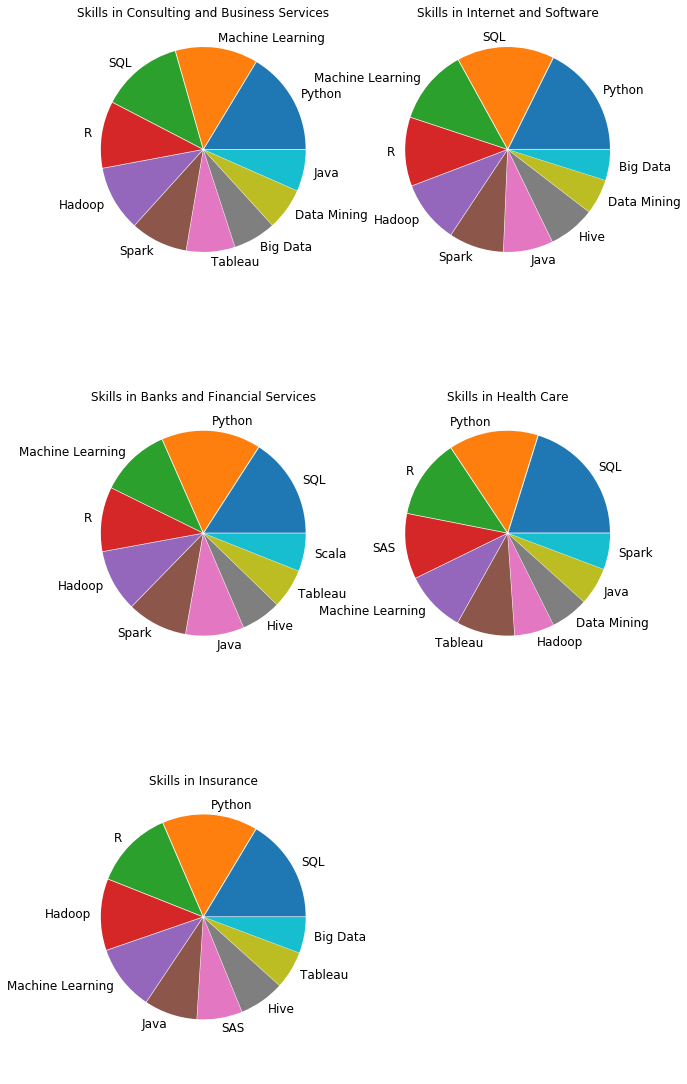

In [46]:
Industry_Skill_dt = {}
industries = ['Consulting and Business Services', 'Internet and Software',
            'Banks and Financial Services', 'Health Care', 'Insurance']
for industry in industries:
    Industry_Skill_dt[industry] = collections.defaultdict(int)
    
def industry_skill_cal(x):
    skill = x['Skill']
    skill_list = extract_skill(skill)
    industry = ''
    for e in industries:
        if x[e] == 1:
            industry = e
            break
    if industry != '':
        for sk in skill_list:
            Industry_Skill_dt[industry][sk] += 1
    
df_indeed.apply(industry_skill_cal, axis=1)
n = 10
explode = [0.01] * n
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.subplots_adjust(wspace=0.8, hspace=0.1)
fig, axes = plt.subplots(3,2,figsize=(10, 20))
for i in range(len(industries)):
    r, c = i // 2, i % 2
    labels = sorted(Industry_Skill_dt[industries[i]].keys(), key=lambda x:Industry_Skill_dt[industries[i]][x], reverse=True)[:n]
    print(industries[i], labels)
    axes[r][c].pie([Industry_Skill_dt[industries[i]][l] for l in labels], labels=labels, explode=explode)
    axes[r][c].set_title('Skills in {}'.format(industries[i]))
axes[2][1].set_axis_off()
plt.show()

Generally, five industries all requires Python, SQL, R and Machine Learning a lot.
* Only in Internet and Software, the **Tableau** does not appear in top10.
* In Health Care, the **SAS** has been put more emphasis.

### <div id='ind5'>2.5 Skills Clusters</div>
In this section, we are going to cluster all the skills we found.

['Python', 'SQL', 'Machine Learning', 'R', 'Hadoop', 'Spark', 'Java', 'Tableau', 'Data Mining', 'Hive', 'SAS', 'Big Data', 'AWS', 'Scala', 'NoSQL', 'C/C++', 'Natural Language Processing', 'Oracle', 'Data Warehouse', 'Linux', 'AI', 'Microsoft SQL Server', 'TensorFlow', 'Kafka', 'Data Analysis', 'Azure', 'MATLAB', 'Microsoft Office', 'Scripting', 'Pig', 'Git', 'Microsoft Powerpoint', 'Excel', 'Design Experience', 'JavaScript', 'HBase', 'PostgreSQL', 'Cassandra', 'Perl', 'MySQL', 'SPSS', 'Software Development', 'Shell Scripting', 'Data Science', 'Docker', 'MongoDB', '.Net', 'Project Management', 'Business Intelligence', 'S3']


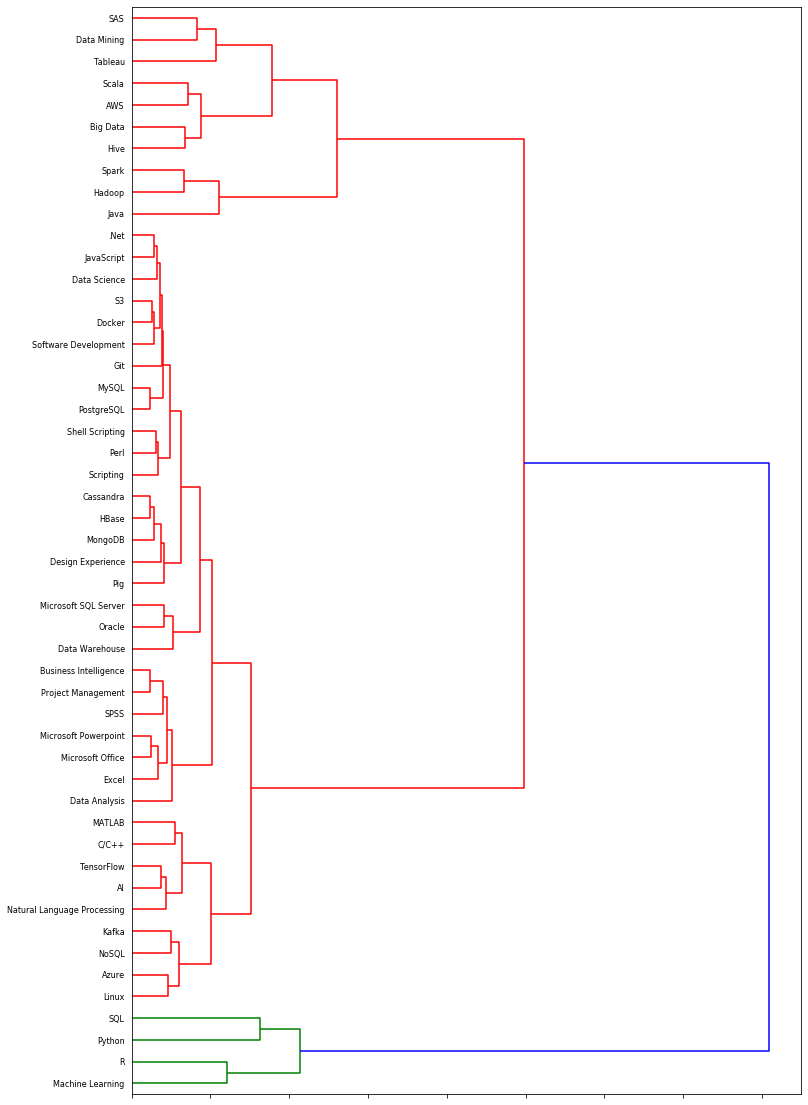

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage,set_link_color_palette

N = len(Skill_Salary_dt.keys())
n = 50 # number of common skills we have
skills_common = sorted(Skill_Salary_dt.keys(), key=lambda x:len(Skill_Salary_dt[x]), reverse=True)[:n]
print(skills_common)

skills_dict = {val : idx for idx, val in enumerate(skills_common)}
skills_data = [[0 for _ in range(n)] for _ in range(n)]

def coexist(x):
    skill = x['Skill']
    skill_list = extract_skill(skill)
    for sk1 in skill_list:
        for sk2 in skill_list:
            if sk1 in skills_common and sk2 in skills_common:
                ind1 = skills_dict[sk1]
                ind2 = skills_dict[sk2]
                skills_data[ind1][ind2] += 1
                skills_data[ind2][ind1] += 1

df_indeed.apply(coexist, axis=1)

Z = linkage(skills_data, 'ward')

#set_link_color_palette(['c', 'm', 'y', 'k'])
fig, ax = plt.subplots(figsize=(12,20))
#ax = fig.add_axes([0.1,0.1,0.4,0.6])
D = dendrogram(Z, orientation='right')
labels = [skills_common[i] for i in D['leaves']]
ax.set_xticklabels([])
ax.set_yticklabels(labels, fontsize=8)
plt.show()

## <div id="test">Reference</div>
* https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
* https://www.nltk.org/book
* https://www.github.com/csurfer/rake-nltk